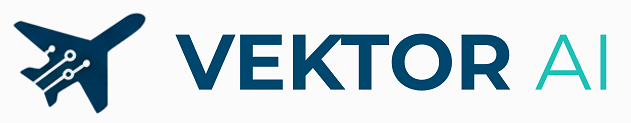

# **Modelos Predictivos 2 - Random Forest para las quince Aerolíneas**


 Con el objetivo de mejorar la predicción, se incorporaron las quince aerolíneas presentes en el intervalo de tiempo de un año. Se realiza una análisis exploratorio y limpieza antes de aplicar un modelo de random forest para las variables seleccionadas por el experto con balanceo de datos, "label encoding" y RandomizedSearchCV.

 Para el uso de la variable de fecha ```FL_DATE```y con el objetivo de no perder información temporal cíclica se crearon las siguientes variables para evitar colinealidad y ruido:

 * mes_sin / mes_cos (Capturan estacionalidad anual (Enero ≈ Diciembre))

* dia_semana_sin / dia_semana_cos (Capturan patrón semanal (Lunes ≈ Domingo))*

* es_fin_de_semana (Señal clara y simple para Random Forest)


# **0. Descripción de las Variables**

**Time Period:**

QUARTER: Quarter (1-4)

MONTH: Month

DAY_OF_MONTH: Day of the Month

DAY_OF_WEEK: Day of the week

FL_DATE: Flight Date (yyymmdd)

**Airline**

OP_UNIQUE_CARRIER: Unique Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2). Use this field for analysis across a range of years.

TAIL_NUM: Tail Number

OP_CARRIER_FL_NUM: Flight Number

**Origin**

ORIGIN_AIRPORT_ID: Origin Airport, Airport ID. An identification number assigned by US DOT to identify a unique airport. Use this field for airport analysis across a range of years because an airport can change its airport code and airport codes can be reused.

ORIGIN: Origin Airport

**Destination**

DEST_AIRPORT_ID: Destination Airport, Airport ID. An identification number assigned by US DOT to identify a unique airport. Use this field for airport analysis across a range of years because an airport can change its airport code and airport codes can be reused.

DEST: Destination Airport

**Departure Performance**

CRS_DEP_TIME: CRS Departure Time (local time: hhmm)

DEP_TIME: Actual Departure Time (local time: hhmm)

DEP_DELAY: Difference in minutes between scheduled and actual departure time. Early departures show negative numbers.

DEP_DEL15: Departure Delay Indicator, 15 Minutes or More (1=Yes)

**Arrival Performance**

CRS_ARR_TIME: CRS Arrival Time (local time: hhmm)

ARR_TIME: Actual Arrival Time (local time: hhmm)

ARR_DELAY: Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers.

ARR_DEL15: Arrival Delay Indicator, 15 Minutes or More (1=Yes)

**Flight Summaries**

ACTUAL_ELAPSED_TIME: Elapsed Time of Flight, in Minutes

**Cause of Delay (Data starts 6/2003)**

CARRIER_DELAY: Carrier Delay, in Minutes

WEATHER_DELAY: Weather Delay, in Minutes

NAS_DELAY: National Air System Delay, in Minutes

SECURITY_DELAY: Security Delay, in Minutes

LATE_AIRCRAFT_DELAY: Late Aircraft Delay, in Minutes

**Gate Return Information at Origin Airport (Data starts 10/2008)**

HAS_FIRST_DEP_TIME: First Gate Departure Time at Origin Airport

HAS_TOTAL_ADD_GTIME Total Ground Time Away from Gate for Gate Return or Cancelled Flight

FECHA_PARTIDA  para Backend ("YYYY-MM-DD-TH:M:S")

# **PARTE I: EDA Y LIMPIEZA DE DATOS**

## **1. Importación de Datos**

Para facilitar el acceso a los datos, se cargaron en Kaggle, de manera que Colab los accese de forma directa desde esa plataforma.

In [ ]:
# The following code will only execute
# successfully when compression is complete

import kagglehub

# Download latest version
path = kagglehub.dataset_download("spmv1980/hackaton-2025-equipo-71")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'hackaton-2025-equipo-71' dataset.
Path to dataset files: /kaggle/input/hackaton-2025-equipo-71


In [ ]:
# Revisar contenido de la carpeta descargada
import os

for root, dirs, files in os.walk(path):
    print(f"\nDirectory: {root}")
    for file in files:
        print("  ", file)


Directory: /kaggle/input/hackaton-2025-equipo-71
   df_procesado.csv
   tail_map.csv
   flight_delays_15_aerolineas.csv
   flight_delays_one_year_2a.csv
   flight_delays_one_year.csv
   df_procesado_todas las aerolneas.csv


In [ ]:
import pandas as pd

# Transtat Octubre 2024 a Septiembre 2025 35 variables (7.024.403 registros)
df_raw = pd.read_csv(os.path.join(path +"/flight_delays_15_aerolineas.csv"))

In [ ]:
df=df_raw.copy()

In [ ]:
df.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM',
       'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID',
       'ORIGIN_CITY_MARKET_ID', 'ORIGIN', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'CRS_DEP_TIME',
       'DEP_TIME', 'DEP_DELAY', 'DEP_DEL15', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY', 'ARR_DEL15', 'CANCELLED', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'FLIGHTS', 'DISTANCE', 'WEATHER_DELAY',
       'FIRST_DEP_TIME', 'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME'],
      dtype='object')

In [ ]:
df.shape

(7024403, 37)

In [ ]:
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,...,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,FLIGHTS,DISTANCE,WEATHER_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME
0,2024,4,10,1,2,10/1/2024 12:00:00 AM,9E,20363,9E,N132EV,...,0.0,0.0,117.0,135.0,1.0,431.0,0.0,NaN,NaN,NaN
1,2024,4,10,1,2,10/1/2024 12:00:00 AM,9E,20363,9E,N132EV,...,0.0,0.0,118.0,111.0,1.0,599.0,33.0,NaN,NaN,NaN
2,2024,4,10,1,2,10/1/2024 12:00:00 AM,9E,20363,9E,N132EV,...,0.0,0.0,133.0,128.0,1.0,599.0,43.0,NaN,NaN,NaN
3,2024,4,10,1,2,10/1/2024 12:00:00 AM,9E,20363,9E,N132EV,...,0.0,0.0,120.0,125.0,1.0,569.0,0.0,NaN,NaN,NaN
4,2024,4,10,1,2,10/1/2024 12:00:00 AM,9E,20363,9E,N132EV,...,0.0,0.0,112.0,117.0,1.0,416.0,0.0,NaN,NaN,NaN


## **2. Corrección de tipo de Variables**


In [ ]:
# Ver tipo de variables de cada columna
pd.set_option('display.max_rows', None) # Muestre todas las filas
df.dtypes

,0
YEAR,int64
QUARTER,int64
MONTH,int64
DAY_OF_MONTH,int64
DAY_OF_WEEK,int64
FL_DATE,object
OP_UNIQUE_CARRIER,object
OP_CARRIER_AIRLINE_ID,int64
OP_CARRIER,object
TAIL_NUM,object


### **2.1 Variables categóricas**

Se corrige el tipo de variables de variables que son categóricas.

In [ ]:
# Cambiar variables a category
cols = ["YEAR", "QUARTER", "MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "OP_UNIQUE_CARRIER", "OP_CARRIER_AIRLINE_ID",
		"OP_CARRIER","OP_CARRIER_FL_NUM","ORIGIN_AIRPORT_ID","ORIGIN_AIRPORT_SEQ_ID","ORIGIN_CITY_MARKET_ID",
		"ORIGIN",	"DEST_AIRPORT_ID","DEST_AIRPORT_SEQ_ID","DEST_CITY_MARKET_ID",
		"DEST"]

df[cols] = df[cols].astype("category")

### **2.2 Dejar sólo fecha sin hora 12:00 AM**

Se corrige la fecha de vuelo removiendo la hora asignada por el tipo de datos (12:00 AM en todos los casos).

In [ ]:
cols2 = ["CRS_DEP_TIME", "DEP_TIME",
"CRS_ARR_TIME","ARR_TIME", "FIRST_DEP_TIME","TOTAL_ADD_GTIME","LONGEST_ADD_GTIME"]

In [ ]:
df[cols2] = df[cols2].apply(
    lambda s: (
        s.astype("Int64")                 # quita .0 y conserva NaN para corregir datos como 1520.0
         .astype(str)
         .replace("<NA>", pd.NA)
         .str.zfill(4)                    # HHMM
         .pipe(pd.to_datetime, format="%H%M", errors="coerce")
         .dt.time                         # resultado: datetime.time + NaT
    )
)

### **2.3 Cambiar tipo de variable a int**

Se corrige tipo de variable a número entero.

In [ ]:
cols4 = ["FLIGHTS"]
df[cols4] = df[cols4].astype("Int64")

## **3. Variable Objetivo - DEP_DEL15**

```DEP_DEL15``` [0=No, 1=Sí]

```DEP_DEL15``` tiene 2 categorías y 85594 valores nulos. Requiere limpieza.

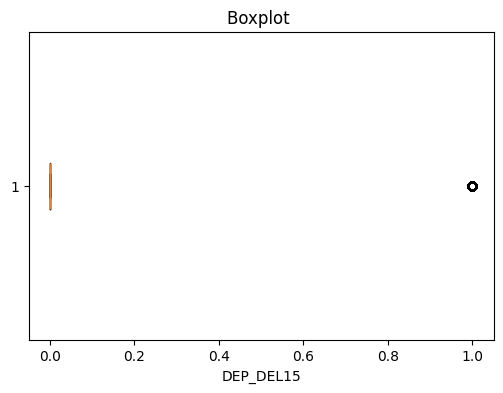

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.boxplot(df["DEP_DEL15"].dropna(), vert=False)
plt.xlabel("DEP_DEL15")
plt.title("Boxplot ")
plt.show()

In [ ]:
df["DEP_DEL15"].isna().sum()

np.int64(85594)

In [ ]:
df["DEP_DEL15"].nunique()

2

In [ ]:
df["DEP_DEL15"].value_counts()

,count
DEP_DEL15,
0.0,5527748
1.0,1411061


In [ ]:
df["DEP_DEL15"].value_counts(normalize=True).mul(100).round(2)

,proportion
DEP_DEL15,
0.0,79.66
1.0,20.34


## **4. Análisis de Variables Continuas**

### **4.1 FL_DATE**

``FL_DATE`` sin valores nulos ni inconsistencias.

In [ ]:
# Función para gráfico específico por mes
df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])

def plot_flights_by_day(df, month, month_name):
    month_df = df[df["FL_DATE"].dt.month == month]

    day_counts = (
        month_df["FL_DATE"]
        .dt.day
        .value_counts()
        .sort_index()
    )

    plt.figure(figsize=(16, 6))
    bars = plt.bar(day_counts.index, day_counts.values)

    plt.xlabel("Day of month")
    plt.ylabel("Number of flights")
    plt.title(f"Number of flights by day – {month_name}")

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{int(height)}",
            ha="center",
            va="bottom",
            fontsize=8
        )

    plt.show()

/tmp/ipython-input-4040137290.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])


In [ ]:
# Función para calcular número de vuelos mínimos, promedio y máximos por mes
def stats_min_mean_max(df, month, month_name):
    day_counts = (
        df[df["FL_DATE"].dt.month == month]["FL_DATE"]
        .dt.day
        .value_counts()
        .sort_index()
    )

    stats = day_counts.agg(["min", "mean", "max"])

    print(f"\n{month_name}")
    print(stats)

Validar que el proceso previo de conversión a datetime no dejó inconsistencias y preparar la visualización

In [ ]:
import pandas as pd
import numpy as np

# 1. Regla de Validación: Verificar nulos tras la conversión a datetime
# (Asumiendo que ya se corrió el proceso de conversión previo)
nulos_fl_date = df['FL_DATE'].isna().sum()

# 2. Generar Insumo: Representación para análisis visual
# Se crea un indicador de "Fecha Válida" para el reporte de calidad
df['VAL_FL_DATE'] = df['FL_DATE'].notna()

# 3. Preparar visualización como dt.date (según requerimiento de negocio)
# Esto es solo para inspección, no altera el tipo datetime de la columna original
ejemplo_fechas = df['FL_DATE'].unique()[:5]

print(f"EDA - FL_DATE:")
print(f"Inconsistencias (Nulos): {nulos_fl_date}")
print(f"Rango de fechas detectado: {df['FL_DATE'].min()} a {df['FL_DATE'].max()}")

EDA - FL_DATE:
Inconsistencias (Nulos): 0
Rango de fechas detectado: 2024-10-01 00:00:00 a 2025-09-30 00:00:00


#### **Octubre 2024**

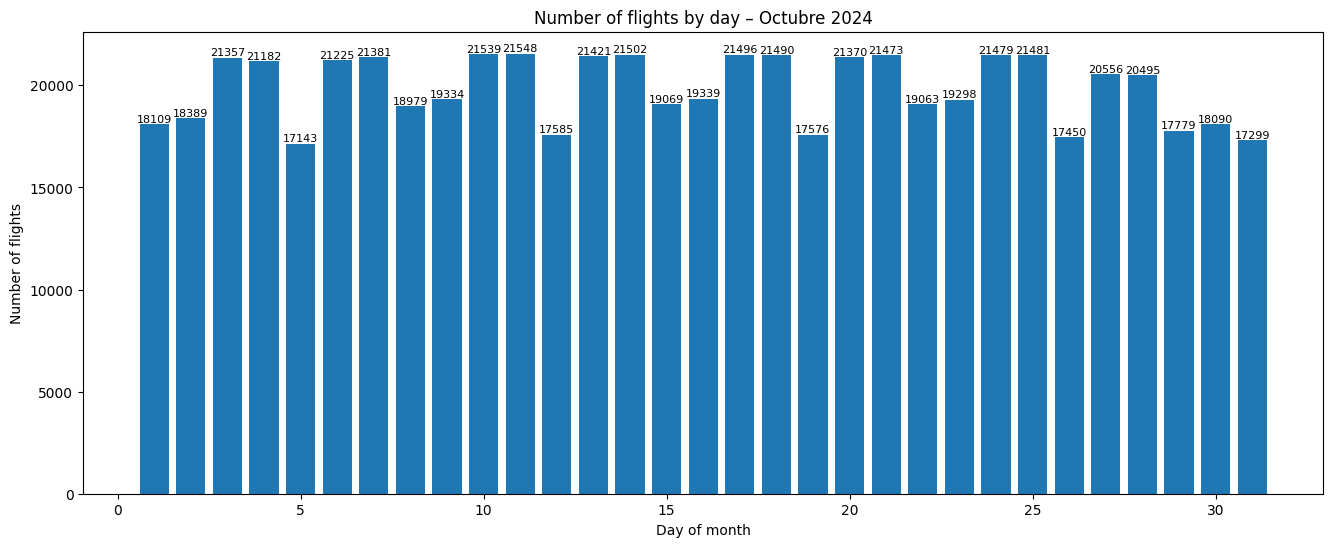

In [ ]:
import matplotlib.pyplot as plt
plot_flights_by_day(df, 10, "Octubre 2024")

In [ ]:
stats_min_mean_max(df, 10, "Octubre 2024")


Octubre 2024
min     17143.000000
mean    19854.741935
max     21548.000000
Name: count, dtype: float64


#### **Noviembre 2024**

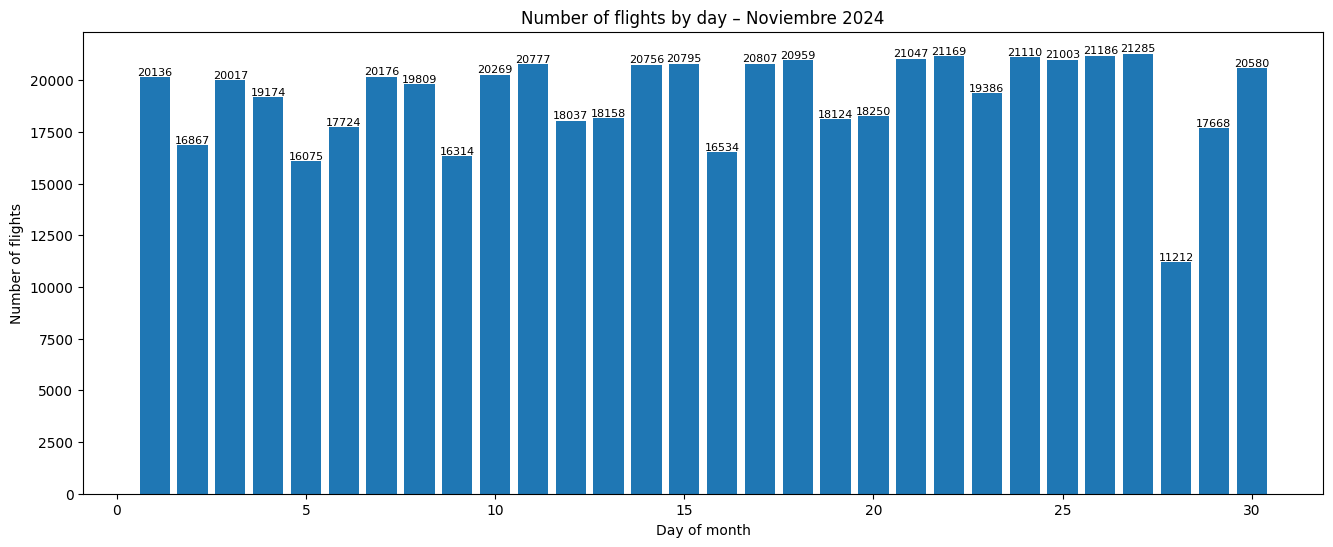

In [ ]:
plot_flights_by_day(df, 11, "Noviembre 2024")

In [ ]:
stats_min_mean_max(df, 11, "Noviembre 2024")


Noviembre 2024
min     11212.000000
mean    19180.133333
max     21285.000000
Name: count, dtype: float64


####**Diciembre 2024**

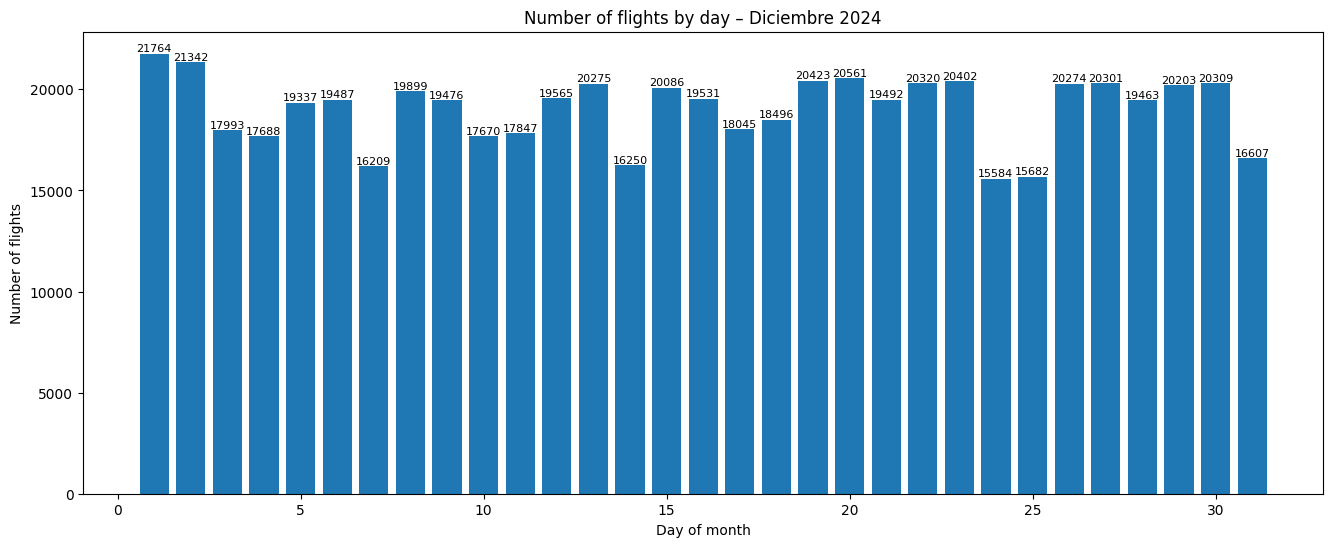

In [ ]:
plot_flights_by_day(df, 12, "Diciembre 2024")

In [ ]:
stats_min_mean_max(df, 12, "Diciembre 2024")


Diciembre 2024
min     15584.0
mean    19051.0
max     21764.0
Name: count, dtype: float64


#### **Enero 2025**

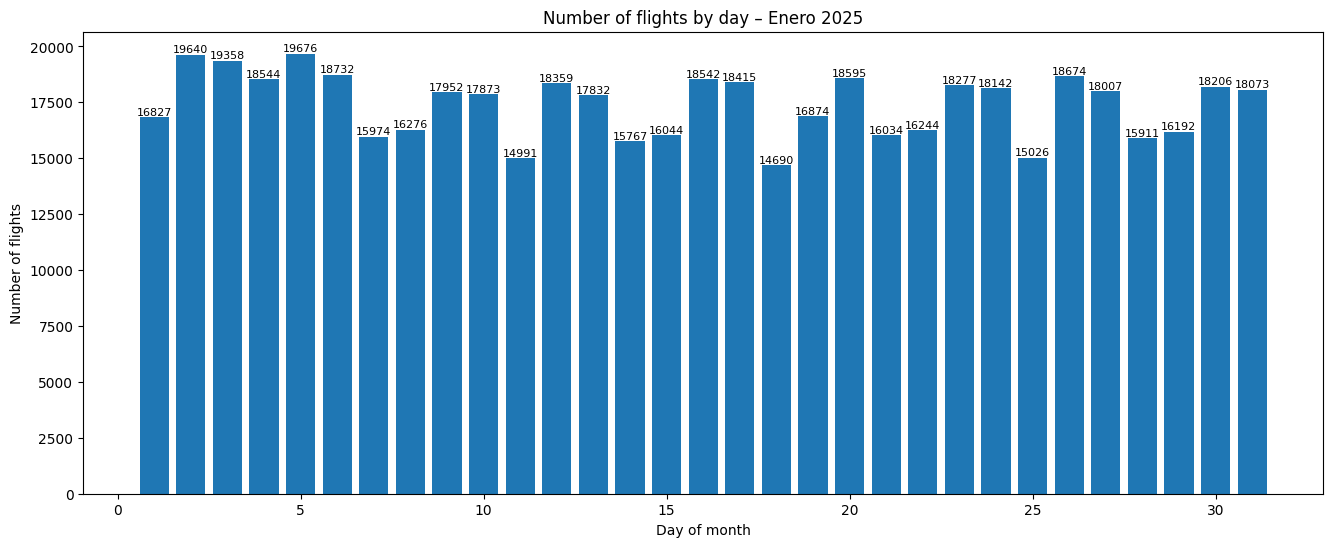

In [ ]:
plot_flights_by_day(df, 1, "Enero 2025")

In [ ]:
stats_min_mean_max(df, 1, "Enero 2025")


Enero 2025
min     14690.000000
mean    17411.193548
max     19676.000000
Name: count, dtype: float64


#### **Febrero 2025**

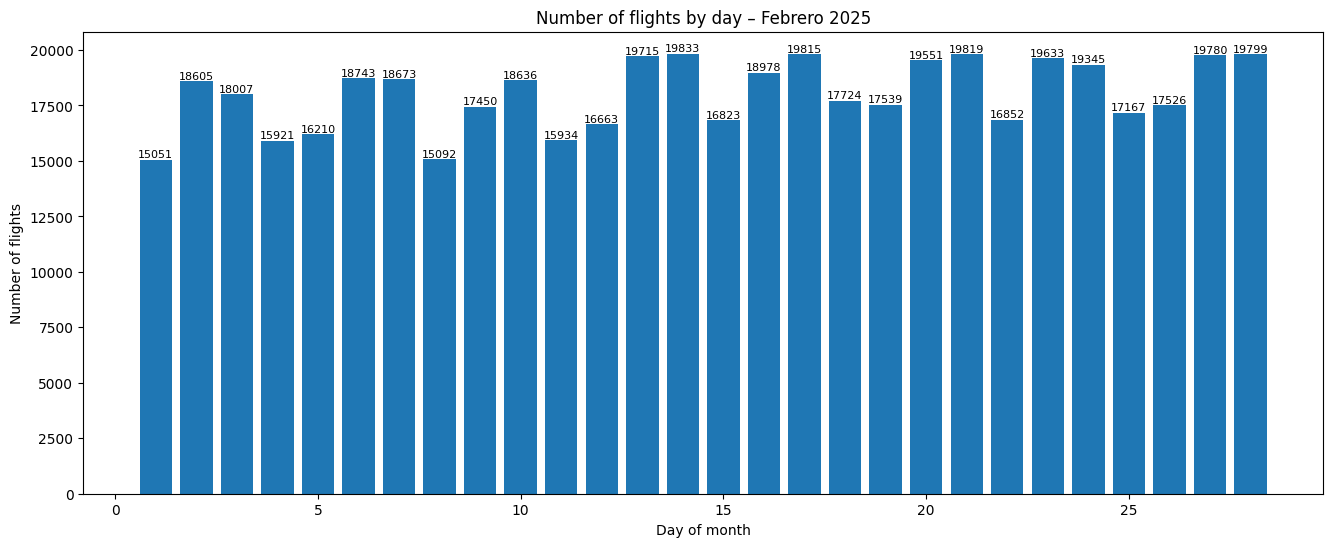

In [ ]:
plot_flights_by_day(df, 2, "Febrero 2025")

In [ ]:
stats_min_mean_max(df, 2, "Febrero 2025")


Febrero 2025
min     15051.000000
mean    18031.571429
max     19833.000000
Name: count, dtype: float64


#### **Marzo 2025**

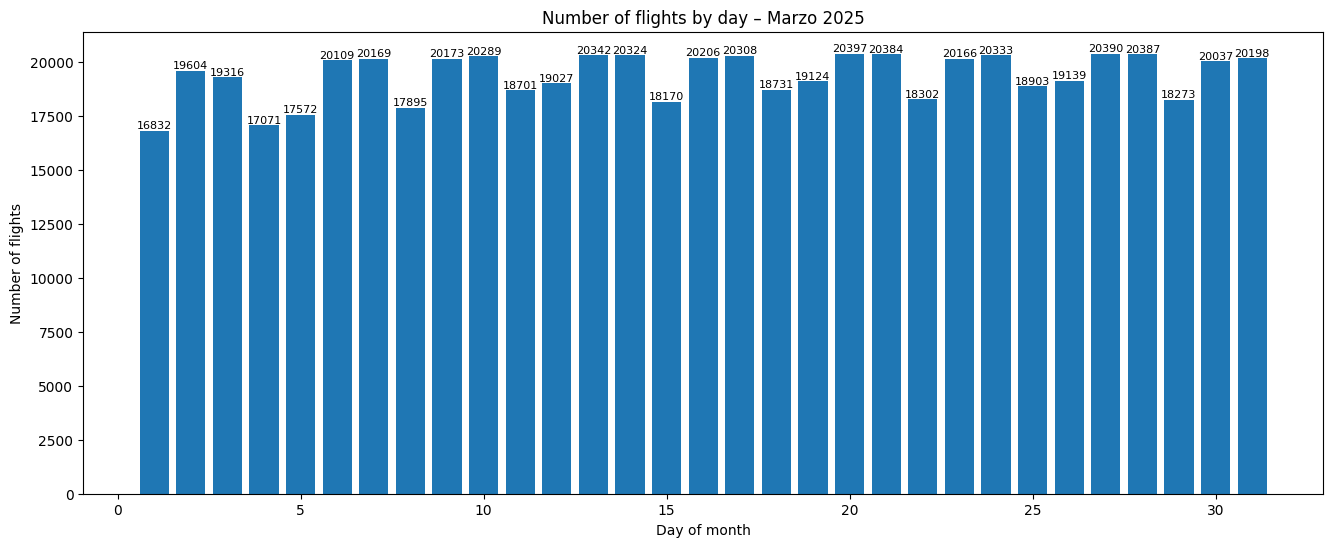

In [ ]:
plot_flights_by_day(df, 3, "Marzo 2025")

In [ ]:
stats_min_mean_max(df, 3, "Marzo 2025")


Marzo 2025
min     16832.000000
mean    19382.967742
max     20397.000000
Name: count, dtype: float64


#### **Abril 2025**

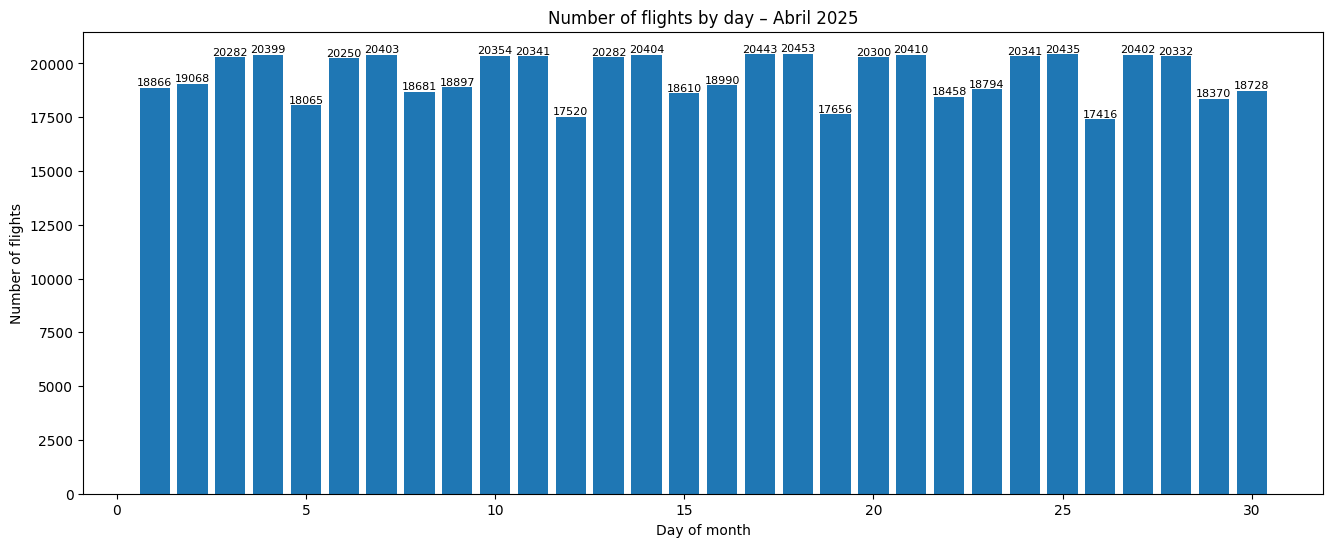

In [ ]:
plot_flights_by_day(df, 4, "Abril 2025")

In [ ]:
stats_min_mean_max(df, 4, "Abril 2025")


Abril 2025
min     17416.0
mean    19465.0
max     20453.0
Name: count, dtype: float64


#### **Mayo 2025**

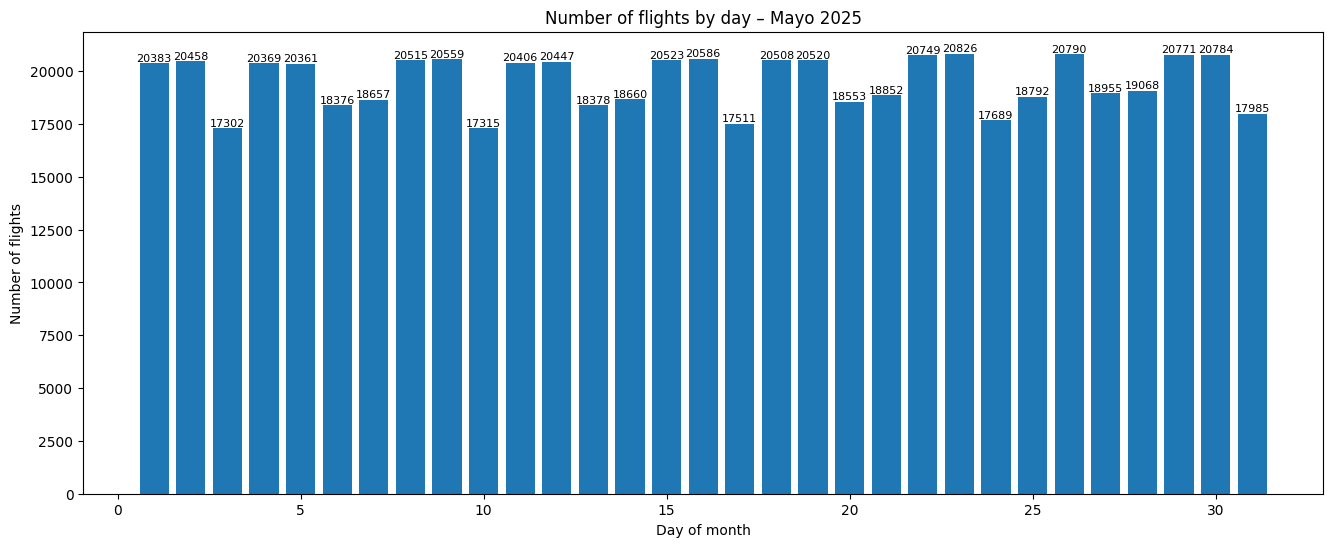

In [ ]:
plot_flights_by_day(df, 5, "Mayo 2025")

In [ ]:
stats_min_mean_max(df, 5, "Mayo 2025")


Mayo 2025
min     17302.000000
mean    19537.032258
max     20826.000000
Name: count, dtype: float64


#### **Junio 2025**

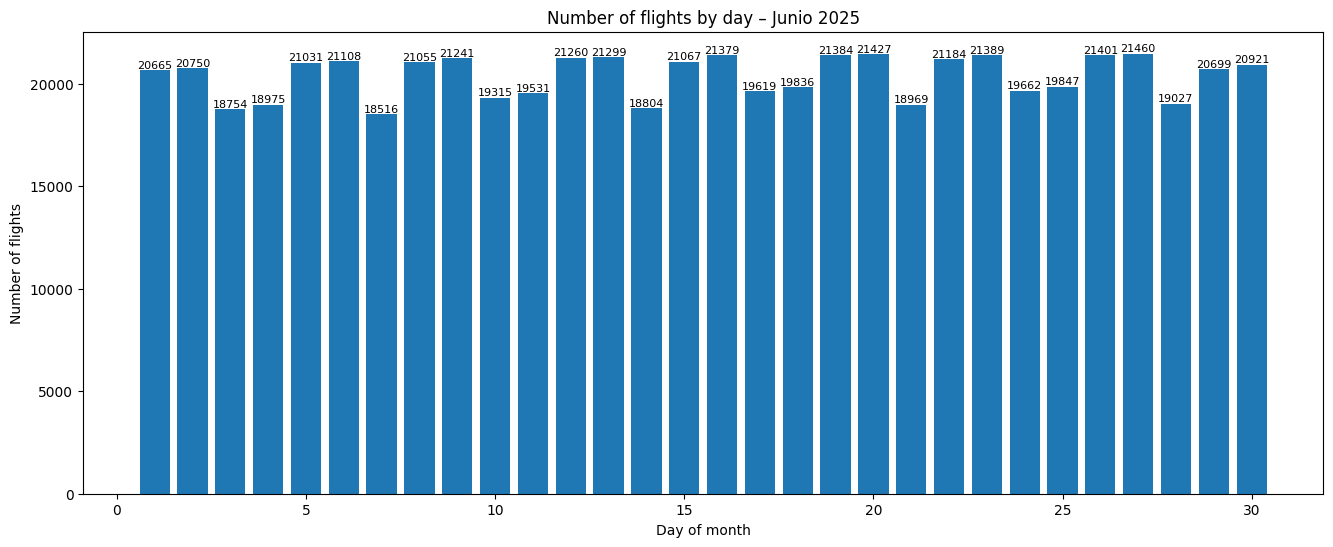

In [ ]:
plot_flights_by_day(df, 6, "Junio 2025")

In [ ]:
stats_min_mean_max(df, 6, "Junio 2025")


Junio 2025
min     18516.000000
mean    20385.833333
max     21460.000000
Name: count, dtype: float64


#### **Julio 2025**

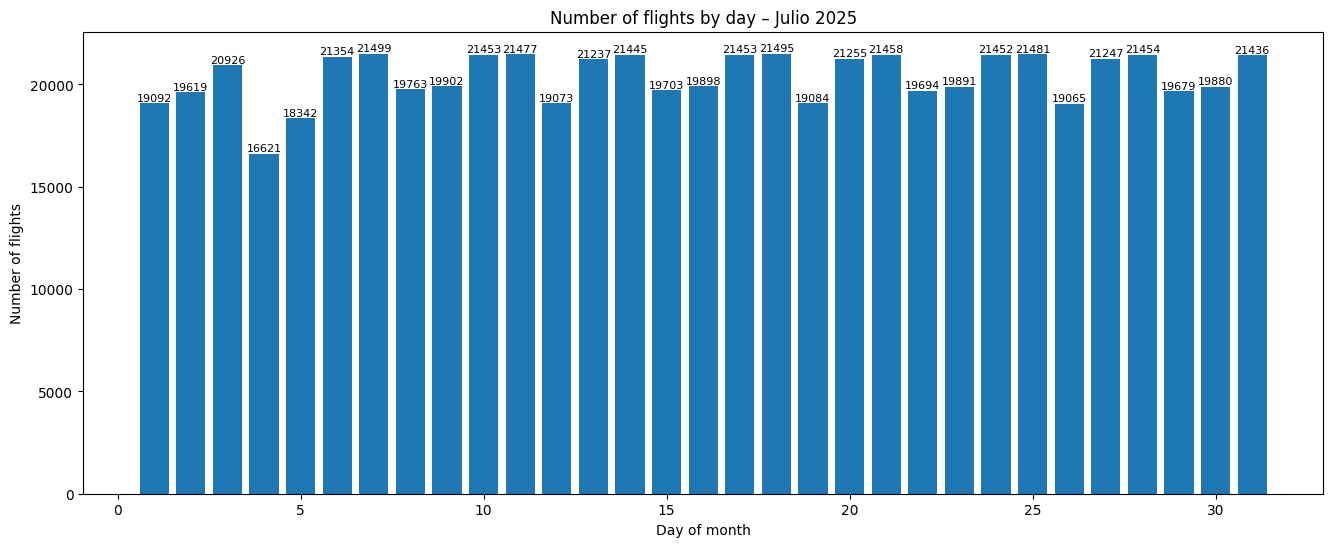

In [ ]:
plot_flights_by_day(df, 7, "Julio 2025")

In [ ]:
stats_min_mean_max(df, 7, "Julio 2025")


Julio 2025
min     16621.000000
mean    20368.645161
max     21499.000000
Name: count, dtype: float64


#### **Agosto 2025**

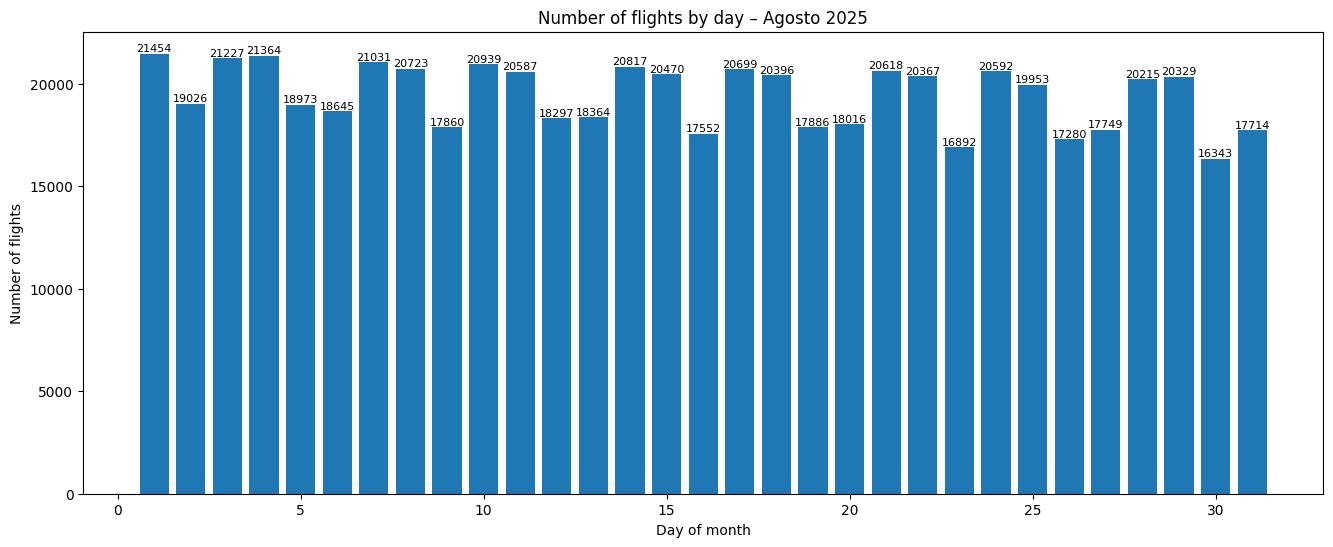

In [ ]:
plot_flights_by_day(df, 8, "Agosto 2025")

In [ ]:
stats_min_mean_max(df, 8, "Agosto 2025")


Agosto 2025
min     16343.000000
mean    19431.548387
max     21454.000000
Name: count, dtype: float64


#### **Septiembre 2025**

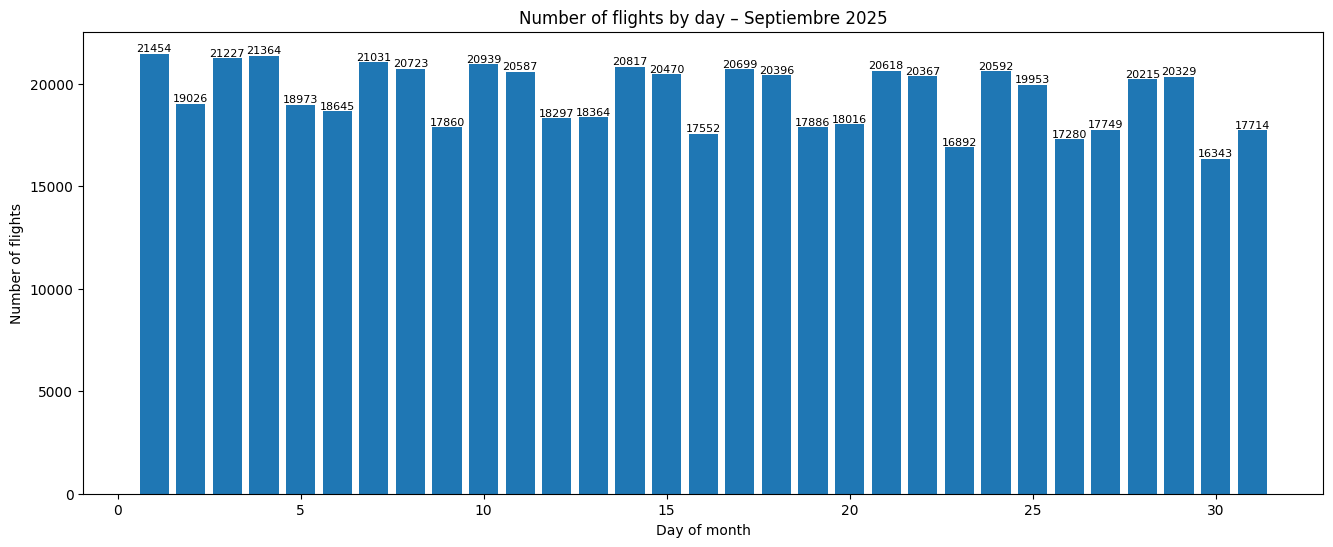

In [ ]:
plot_flights_by_day(df, 8, "Septiembre 2025")

In [ ]:
stats_min_mean_max(df, 9, "Septiembre 2025")


Septiembre 2025
min     15908.000000
mean    18747.966667
max     20386.000000
Name: count, dtype: float64


### **4.2 CRS_DEP_TIME (hhmm)**

```CRS_DEP_TIME``` Tiene un valor nulo

In [ ]:
df["CRS_DEP_TIME"].isna().sum()

np.int64(1)

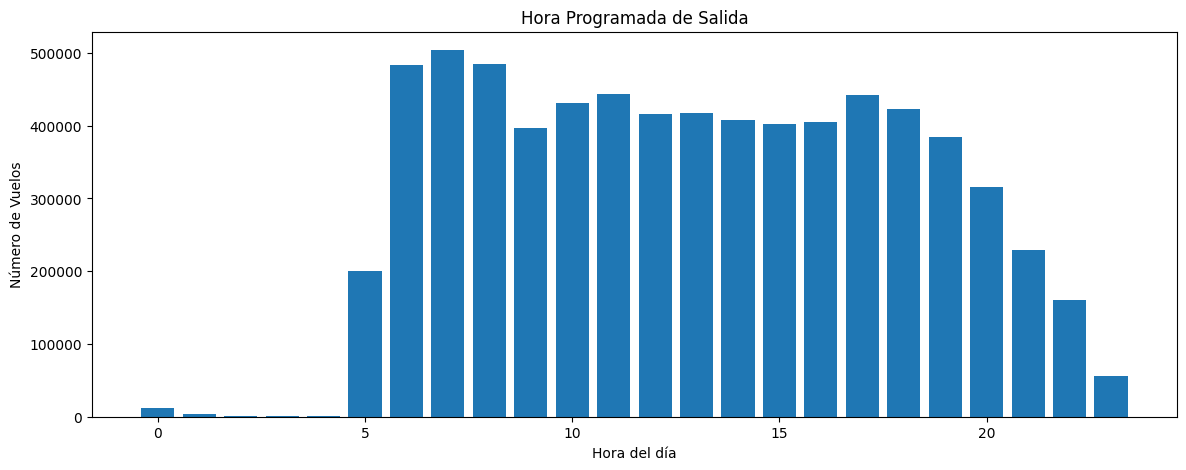

In [ ]:
df["CRS_DEP_HOUR"] = df["CRS_DEP_TIME"].map(lambda t: t.hour)

hour_counts = df["CRS_DEP_HOUR"].value_counts().sort_index()

plt.figure(figsize=(14, 5))
plt.bar(hour_counts.index, hour_counts.values)
plt.xlabel("Hora del día")
plt.ylabel("Número de Vuelos")
plt.title("Hora Programada de Salida")
plt.show()

Validar la calidad de la programación base.

In [ ]:
import pandas as pd
import numpy as np

# After converting to datetime.time, explicit range and minute checks are redundant
# as datetime.time objects enforce valid ranges, and errors='coerce' handles bad formats.
# Therefore, the only inconsistency to check for after conversion is if the value is NaT.
mask_nulo_crs_dep = df['CRS_DEP_TIME'].isna()

# 2. Generar indicadores para la fase de limpieza
df['ERR_CRS_DEP_TIME'] = mask_nulo_crs_dep

print(f"EDA - CRS_DEP_TIME:")
print(f"Registros no parseables (NaT) detectados: {df['ERR_CRS_DEP_TIME'].sum()}")
print(df[df['ERR_CRS_DEP_TIME'] == True][['CRS_DEP_TIME']].head())

EDA - CRS_DEP_TIME:
Registros no parseables (NaT) detectados: 1
        CRS_DEP_TIME
5707064          NaT


In [ ]:
df.drop(columns=['ERR_CRS_DEP_TIME'], inplace=True)

### **4.3 DEP_TIME (hhmm)**

```DEP_TIME``` tiene 85914 valores nulos.

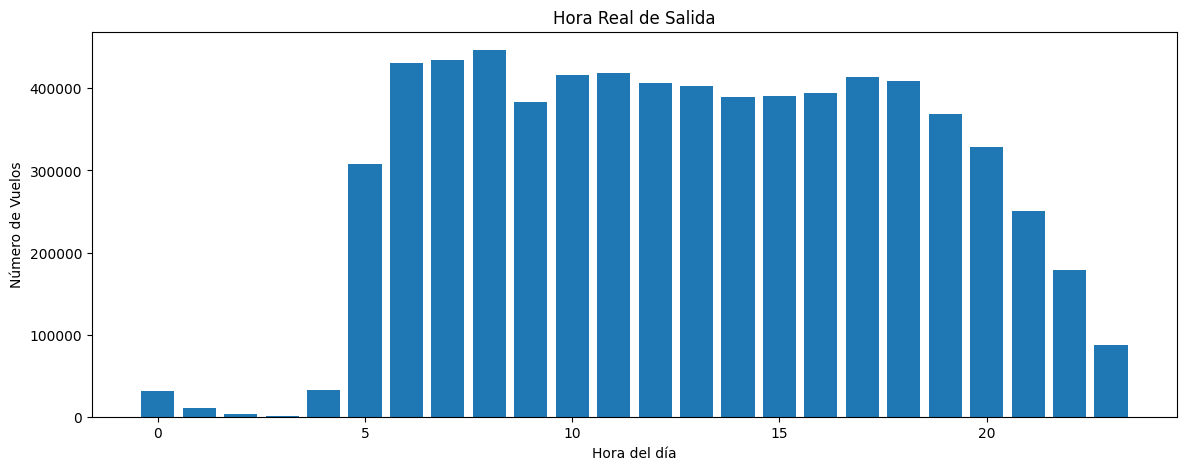

In [ ]:
df["DEP_HOUR"] = df["DEP_TIME"].map(lambda t: t.hour)

hour_counts = df["DEP_HOUR"].value_counts().sort_index()

plt.figure(figsize=(14, 5))
plt.bar(hour_counts.index, hour_counts.values)
plt.xlabel("Hora del día")
plt.ylabel("Número de Vuelos")
plt.title("Hora Real de Salida")
plt.show()

Detectar "ruido" en los minutos y valores fuera de la realidad física. Errores de formato militar y minutos imposibles que generarían ruido en el cálculo del retraso.

In [ ]:
# 1. Regla de Validación: Formato Militar (0-2400) y Minutos (0-59)
# DEP_TIME suele ser float en el raw data (ej. 1430.0)
# After converting to datetime.time, explicit range and minute checks are redundant
# as datetime.time objects enforce valid ranges, and errors='coerce' handles bad formats.
mask_nulo_dep = df['DEP_TIME'].isna()

# 2. Generar Insumo para Limpieza:
# Identify records where the time could not be parsed into a valid datetime.time object.
df['ERR_DEP_TIME'] = mask_nulo_dep

print(f"EDA - DEP_TIME:")
print(f"Valores nulos (o no parseables) detectados: {mask_nulo_dep.sum()}")
# Removed checks for invalid range and minutes as they are implicitly handled by NaNs after conversion.
print(f"Ejemplos de errores detectados (NaNs): {df[mask_nulo_dep]['DEP_TIME'].head(5).tolist()}")


EDA - DEP_TIME:
Valores nulos (o no parseables) detectados: 85914
Ejemplos de errores detectados (NaNs): [NaT, NaT, NaT, NaT, NaT]


In [ ]:
df.drop(columns=['ERR_DEP_TIME'], inplace=True)

### **4.4 DEP_DELAY (Minutes)**

```DEP_DELAY``` tiene 108430 valores nulos.

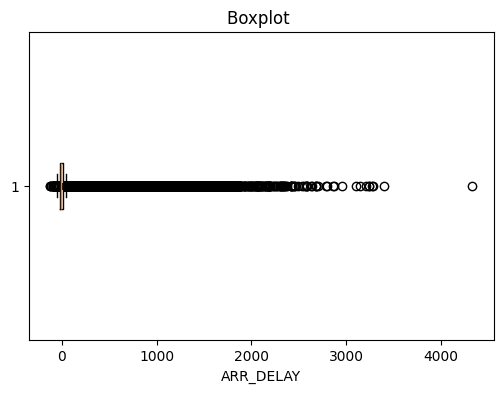

In [ ]:
plt.figure(figsize=(6, 4))
plt.boxplot(df["ARR_DELAY"].dropna(), vert=False)
plt.xlabel("ARR_DELAY")
plt.title("Boxplot ")
plt.show()

In [ ]:
df["ARR_DELAY"].isna().sum()

np.int64(108430)

### **4.5 CRS_ARR_TIME (hhmm)**

```CRS_ARR_TIME``` tiene 7024403 valores nulos.

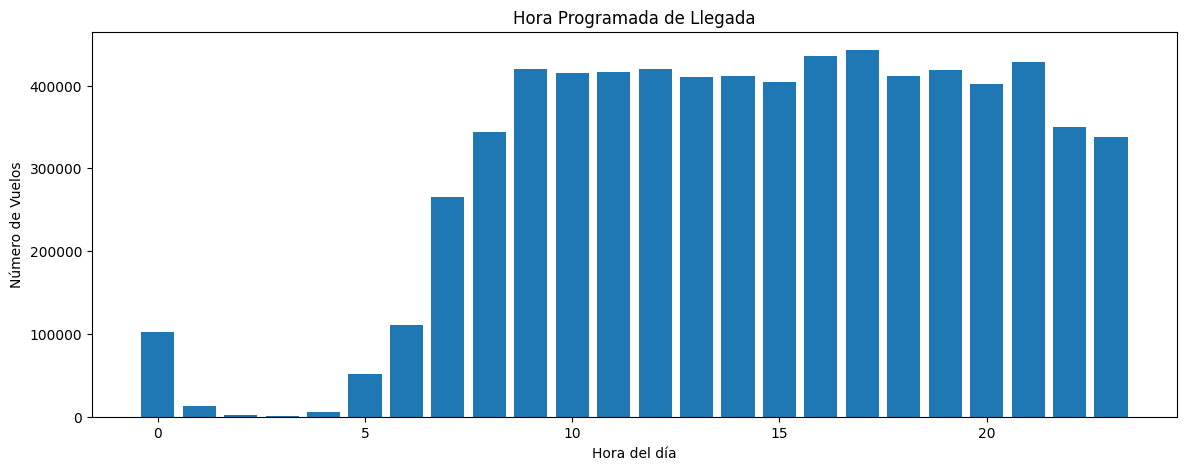

In [ ]:
df["CRS_ARR_HOUR"] = df["CRS_ARR_TIME"].map(lambda t: t.hour)

hour_counts = df["CRS_ARR_HOUR"].value_counts().sort_index()

plt.figure(figsize=(14, 5))
plt.bar(hour_counts.index, hour_counts.values)
plt.xlabel("Hora del día")
plt.ylabel("Número de Vuelos")
plt.title("Hora Programada de Llegada")
plt.show()

Identificar vuelos que cruzan la medianoche.

In [ ]:
# 1. Convertir CRS_ARR_TIME a datetime.time
# Se asume formato militar (HHMM) como float, ej. 1430.0
df['CRS_ARR_TIME'] = pd.to_datetime(df['CRS_ARR_TIME'], format='%H%M', errors='coerce').dt.time

# 2. Generar columna de errores
df['ERR_CRS_ARR_TIME'] = df['CRS_ARR_TIME'].isna()

# 3. Detectar vuelos programados que cruzan medianoche
# Para la comparación, también convertimos CRS_DEP_TIME a datetime.time si no lo está
df['CRS_DEP_TIME'] = pd.to_datetime(df['CRS_DEP_TIME'], format='%H%M', errors='coerce').dt.time

df['IS_OVERNIGHT_SCHEDULED'] = df.apply(
    lambda row: row['CRS_ARR_TIME'] < row['CRS_DEP_TIME'] if pd.notna(row['CRS_ARR_TIME']) and pd.notna(row['CRS_DEP_TIME']) else False,
    axis=1
)

# 4. Reporte rápido
print(f"EDA - CRS_ARR_TIME:")
print(f"Valores nulos o no parseables: {df['ERR_CRS_ARR_TIME'].sum()}")
print(f"Vuelos programados que cruzan medianoche: {df['IS_OVERNIGHT_SCHEDULED'].sum()}")

EDA - CRS_ARR_TIME:
Valores nulos o no parseables: 7024403
Vuelos programados que cruzan medianoche: 0


In [ ]:
df['CRS_ARR_TIME'].isna().sum()

np.int64(7024403)

### **4.6 ARR_TIME (hhmm)**

```ARR_TIME``` tiene 7024403 valores nulos.





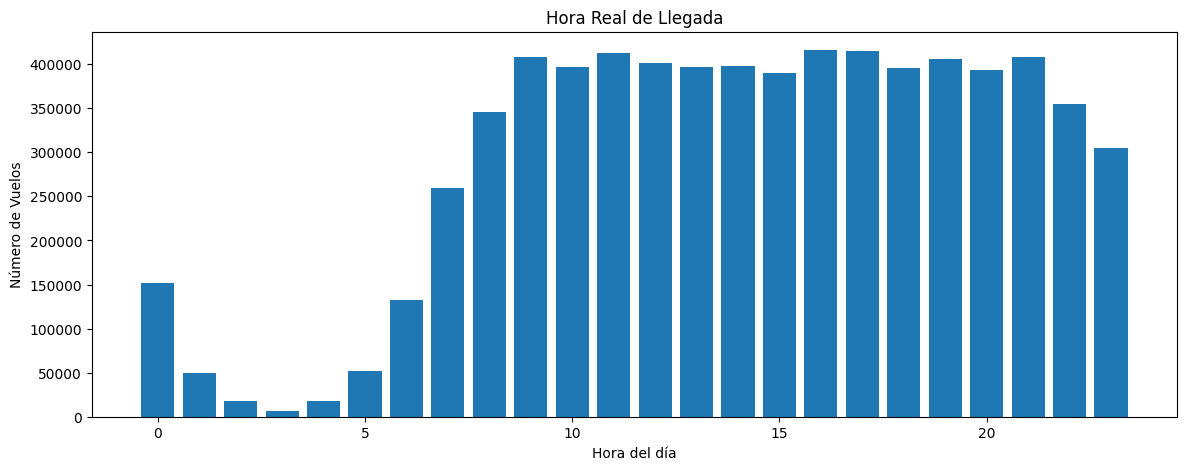

In [ ]:
df["ARR_HOUR"] = df["ARR_TIME"].map(lambda t: t.hour)

hour_counts = df["ARR_HOUR"].value_counts().sort_index()

plt.figure(figsize=(14, 5))
plt.bar(hour_counts.index, hour_counts.values)
plt.xlabel("Hora del día")
plt.ylabel("Número de Vuelos")
plt.title("Hora Real de Llegada")
plt.show()

Cuantificar la pérdida de datos (vuelos cancelados o desviados).

In [ ]:
# 1. Regla de Validación: Formato Militar (0-2400) y Minutos (0-59)
# ARR_TIME suele ser float en el raw data (ej. 1430.0)
# Después de convertir a datetime.time, las verificaciones explícitas de rango y minutos son redundantes
# ya que los objetos datetime.time validan rangos válidos, y errors='coerce' maneja formatos inválidos.

# Convertir ARR_TIME a datetime.time si no se ha hecho aún
df['ARR_TIME'] = pd.to_datetime(df['ARR_TIME'], format='%H%M', errors='coerce').dt.time

# 2. Generar Insumo para Limpieza:
# Identificar registros donde el tiempo no pudo ser parseado a un objeto datetime.time válido.
mask_nulo_arr = df['ARR_TIME'].isna()
df['ERR_ARR_TIME'] = mask_nulo_arr

print(f"EDA - ARR_TIME:")
print(f"Valores nulos (o no parseables) detectados: {mask_nulo_arr.sum()}")
print(f"Ejemplos de errores detectados (NaNs): {df[mask_nulo_arr]['ARR_TIME'].head(5).tolist()}")

EDA - ARR_TIME:
Valores nulos (o no parseables) detectados: 7024403
Ejemplos de errores detectados (NaNs): [NaT, NaT, NaT, NaT, NaT]


### **4.7 ARR_DELAY  (Arrival Delay [min])**

```ARR_DELAY``` tiene 108430 valores nulos.

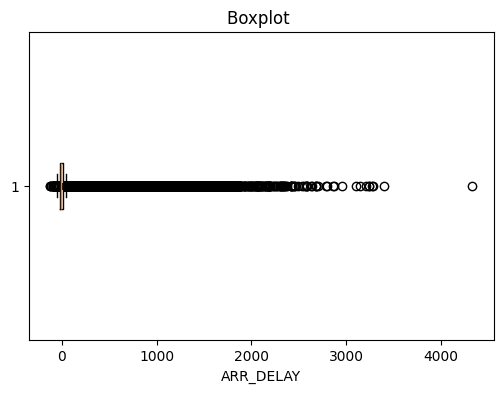

In [ ]:
plt.figure(figsize=(6, 4))
plt.boxplot(df["ARR_DELAY"].dropna(), vert=False)
plt.xlabel("ARR_DELAY")
plt.title("Boxplot ")
plt.show()

In [ ]:
df["ARR_DELAY"].isna().sum()

np.int64(108430)

### **4.8  CRS_ELAPSED_TIME**


```CRS_ELAPSED_TIME``` sin valores nulos.

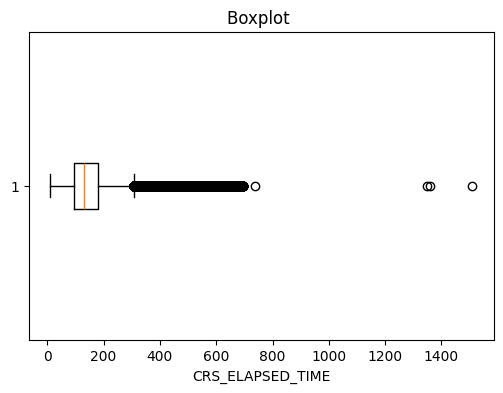

In [ ]:
plt.figure(figsize=(6, 4))
plt.boxplot(df["CRS_ELAPSED_TIME"].dropna(), vert=False)
plt.xlabel("CRS_ELAPSED_TIME")
plt.title("Boxplot ")
plt.show()

In [ ]:
df["CRS_ELAPSED_TIME"].isna().sum()

np.int64(2)

### **4.9 ACTUAL_ELAPSED_TIME**

```ACTUAL_ELAPSED_TIME``` tiene 108430 valores nulos.

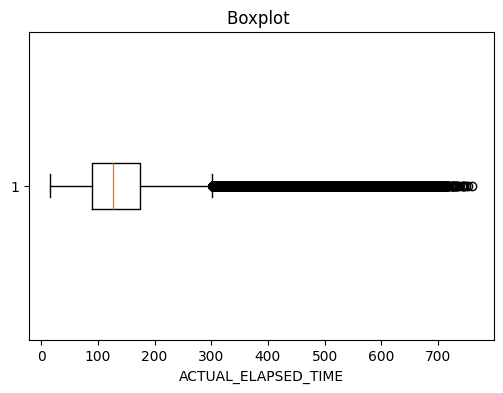

In [ ]:
plt.figure(figsize=(6, 4))
plt.boxplot(df["ACTUAL_ELAPSED_TIME"].dropna(), vert=False)
plt.xlabel("ACTUAL_ELAPSED_TIME")
plt.title("Boxplot ")
plt.show()

In [ ]:
df["ACTUAL_ELAPSED_TIME"].isna().sum()

np.int64(108430)

### **4.10 DISTANCE**

```DISTANCE``` sin valores nulos.

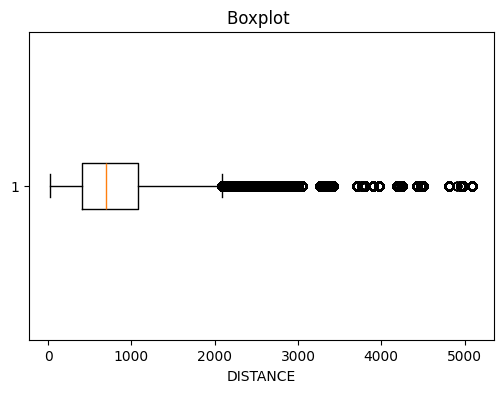

In [ ]:
plt.figure(figsize=(6, 4))
plt.boxplot(df["DISTANCE"].dropna(), vert=False)
plt.xlabel("DISTANCE")
plt.title("Boxplot ")
plt.show()

In [ ]:
df["DISTANCE"].isna().sum()

np.int64(0)

### **4.11 WEATHER_DELAY**

```WEATHER_DELAY``` tiene 5591335 valores nulos.

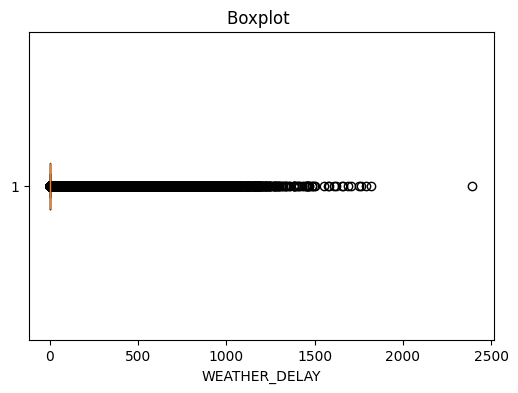

In [ ]:
plt.figure(figsize=(6, 4))
plt.boxplot(df["WEATHER_DELAY"].dropna(), vert=False)
plt.xlabel("WEATHER_DELAY")
plt.title("Boxplot ")
plt.show()

In [ ]:
df["WEATHER_DELAY"].isna().sum()

np.int64(5591335)

### **4.12 FIRST_DEP_TIME**


```FIRST_DEP_TIME``` tiene 6971393 valores nulos.

In [ ]:
df["FIRST_DEP_TIME"].isna().sum()

np.int64(6971393)

### **4.13 TOTAL_ADD_GTIME**


```TOTAL_ADD_GTIME``` tiene 6978862 valores nulos.



In [ ]:
df["TOTAL_ADD_GTIME"].isna().sum()

np.int64(6978862)

### **4.14 LONGEST_ADD_GTIME**

```LONGEST_ADD_GTIME``` tiene 2395794 valores nulos.

In [ ]:
df["LONGEST_ADD_GTIME"].isna().sum()

np.int64(6978653)

## **5. Análisis Variables Categóricas**

### **5.1 YEAR**

```YEAR``` tiene dos categorías (2024 y 2025) y no posee valores nulos

In [ ]:
df["YEAR"].isna().sum()

np.int64(0)

In [ ]:
df['YEAR'].value_counts()

,count
YEAR,
2025,5242921
2024,1781482


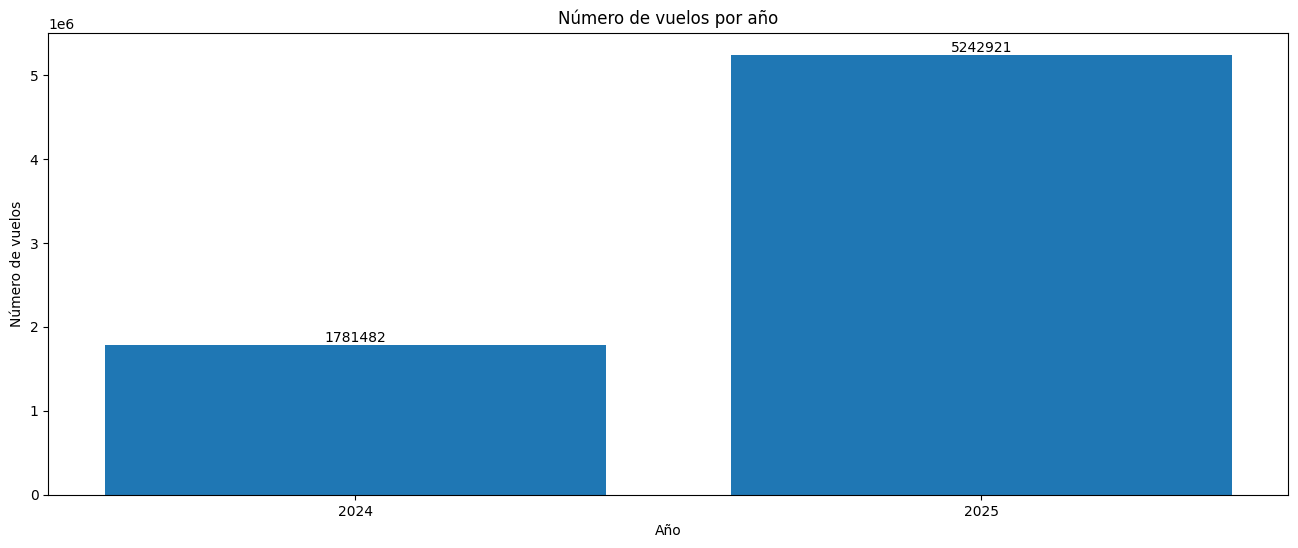

In [ ]:
# Contar observaciones por año
year_counts = df["YEAR"].value_counts().sort_index()

plt.figure(figsize=(16, 6))
bars = plt.bar(year_counts.index.astype(str), year_counts.values)  # Convierte años a texto

plt.xlabel("Año")
plt.ylabel("Número de vuelos")
plt.title("Número de vuelos por año")

# Añadir valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

plt.show()

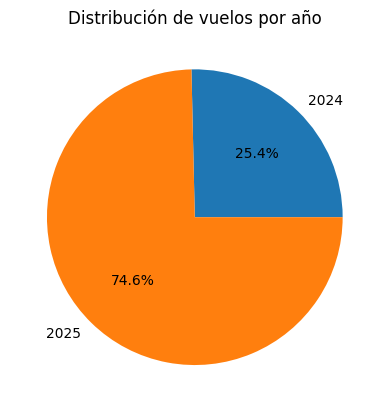

In [ ]:
plt.figure()
plt.pie(
    year_counts.values,
    labels=year_counts.index,
    autopct="%1.1f%%"
)
plt.title("Distribución de vuelos por año")
plt.show()

###**5.2 QUARTER**


```QUARTER``` tiene cuatro categorías (1,2,3,4) y no posee valores nulos.

In [ ]:
df["QUARTER"].isna().sum()

np.int64(0)

In [ ]:
df['QUARTER'].value_counts()

,count
QUARTER,
2,1801173
3,1796245
4,1781482
1,1645503


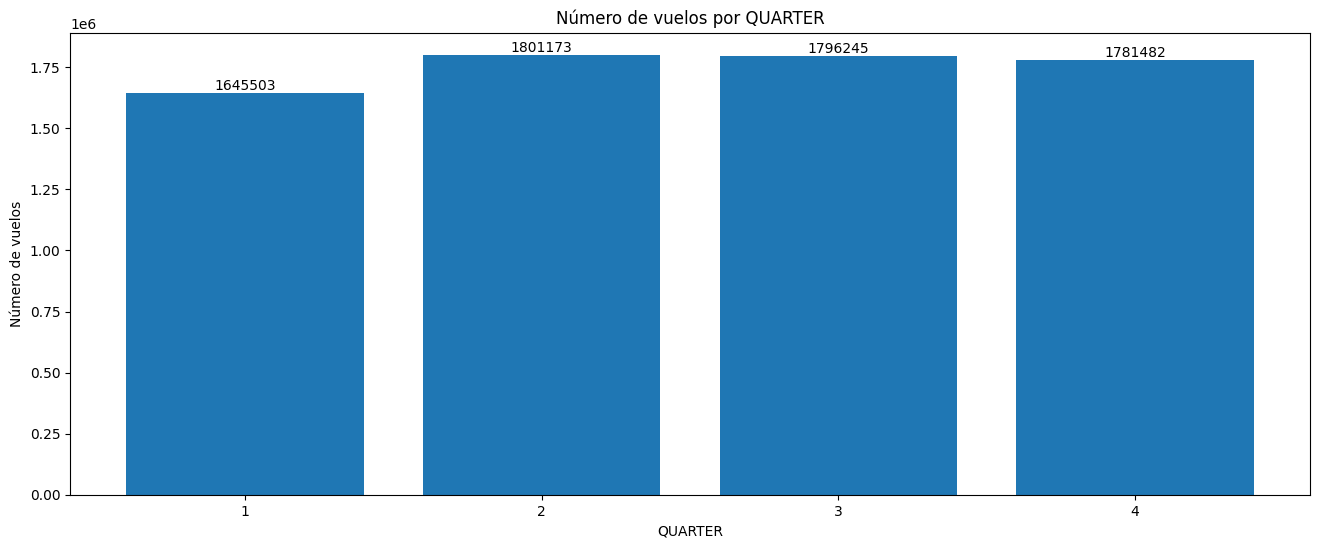

In [ ]:

# Contar observaciones por año
quarter_counts = df["QUARTER"].value_counts().sort_index()

plt.figure(figsize=(16, 6))
bars = plt.bar(quarter_counts .index.astype(str), quarter_counts .values)  # Convierte años a texto

plt.xlabel("QUARTER")
plt.ylabel("Número de vuelos")
plt.title("Número de vuelos por QUARTER")

# Añadir valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

plt.show()

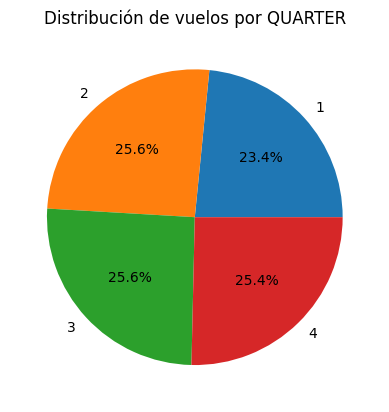

In [ ]:
plt.figure()
plt.pie(
    quarter_counts .values,
    labels=quarter_counts .index,
    autopct="%1.1f%%"
)
plt.title("Distribución de vuelos por QUARTER")
plt.show()

### **5.3 MONTH**

```MONTH``` tiene doce categorías (1-12) y no posee valores nulos.

In [ ]:
df["MONTH"].isna().sum()

np.int64(0)

In [ ]:
df['MONTH'].value_counts()

,count
MONTH,
7,631428
10,615497
6,611575
5,605648
8,602378
3,600872
12,590581
4,583950
11,575404


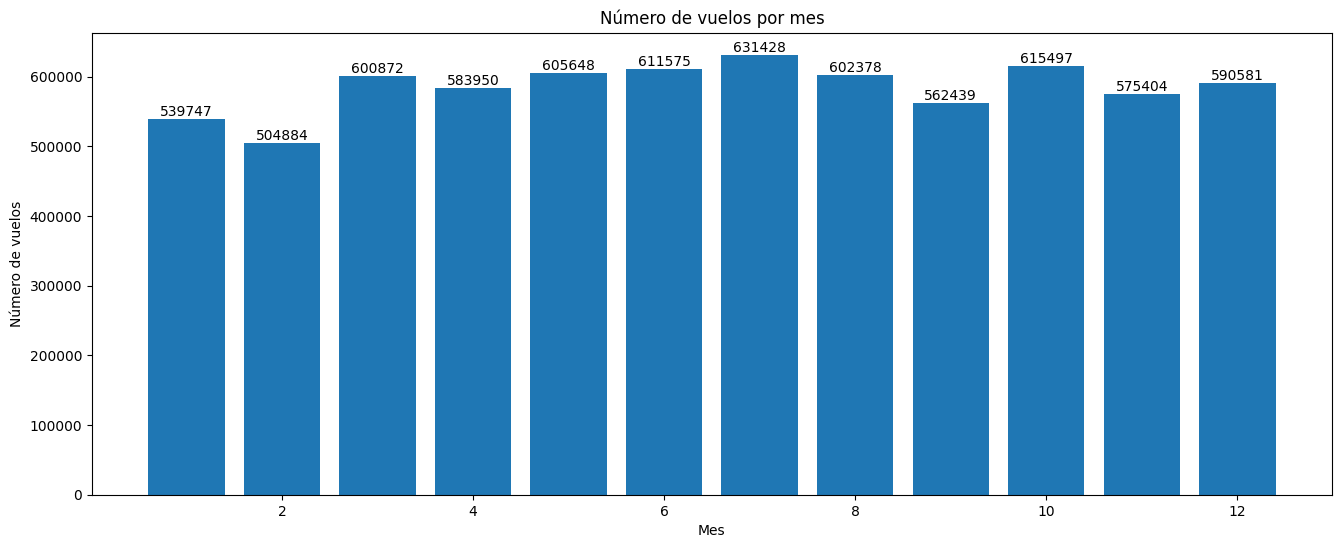

In [ ]:
# Contar observaciones por mes
month_counts = df["MONTH"].value_counts().sort_index()

plt.figure(figsize=(16, 6))
bars = plt.bar(month_counts.index, month_counts.values)

plt.xlabel("Mes")
plt.ylabel("Número de vuelos")
plt.title("Número de vuelos por mes")

# Añadir valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

plt.show()

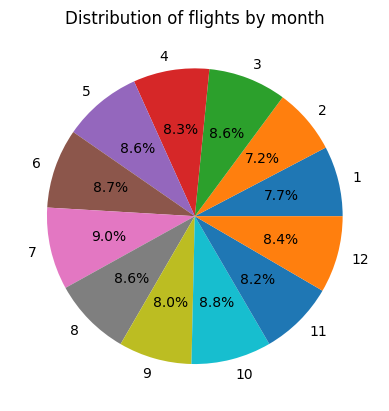

In [ ]:
plt.figure()
plt.pie(
    month_counts.values,
    labels=month_counts.index,
    autopct="%1.1f%%"
)
plt.title("Distribution of flights by month")
plt.show()

### **5.4 DAY_OF_MONTH**

```DAY_OF_MONTH``` tiene 31 categorías y no posee valores nulos.

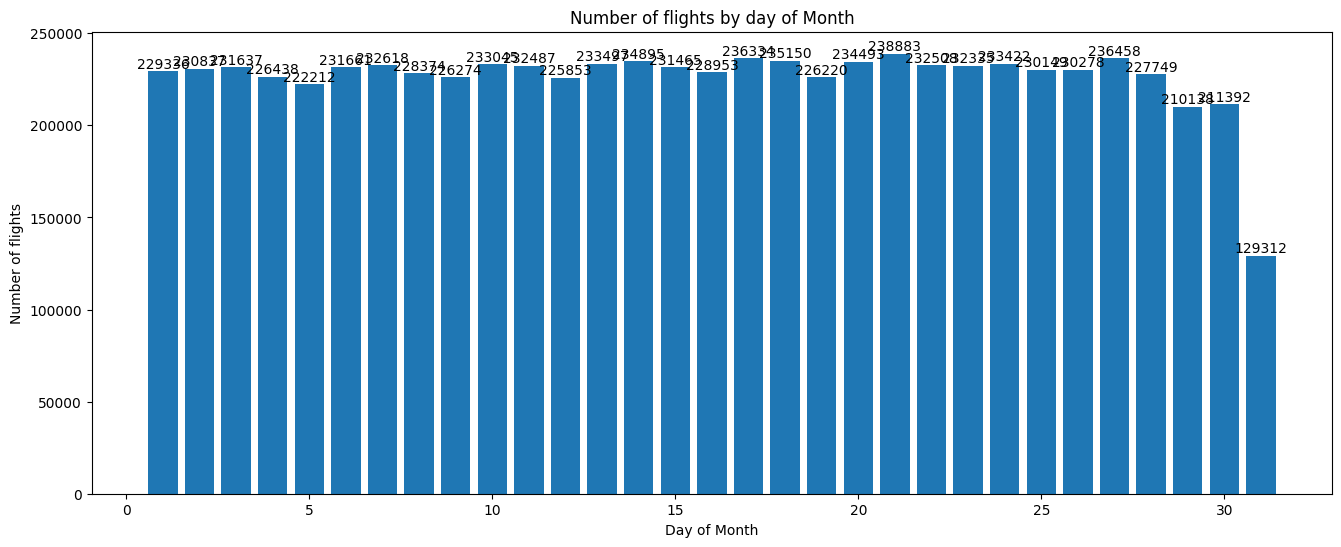

In [ ]:
# Contar observaciones por mes
month_counts = df["DAY_OF_MONTH"].value_counts().sort_index()

plt.figure(figsize=(16, 6))
bars = plt.bar(month_counts.index, month_counts.values)

plt.xlabel("Day of Month")
plt.ylabel("Number of flights")
plt.title("Number of flights by day of Month")

# Añadir valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

plt.show()

In [ ]:
df["DAY_OF_MONTH"].isna().sum()

np.int64(0)

### **5.5 DAY_OF_WEEK**

```DAY_OF_WEEK``` tiene 7 categorías y no posee valores nulos.

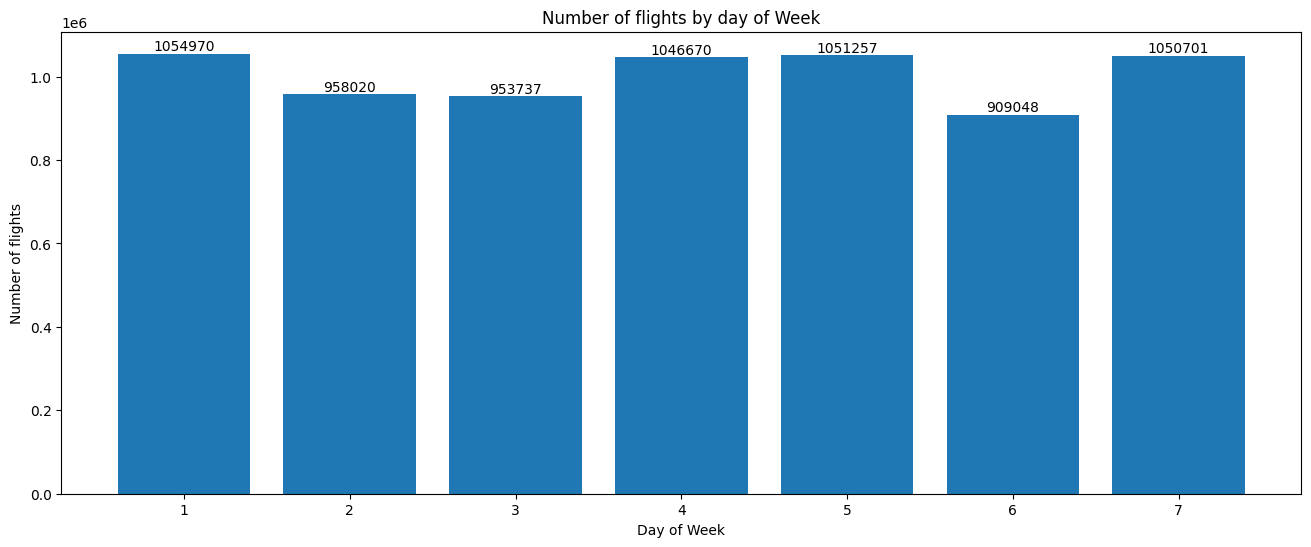

In [ ]:
# Contar observaciones por mes
month_counts = df["DAY_OF_WEEK"].value_counts().sort_index()

plt.figure(figsize=(16, 6))
bars = plt.bar(month_counts.index, month_counts.values)

plt.xlabel("Day of Week")
plt.ylabel("Number of flights")
plt.title("Number of flights by day of Week")

# Añadir valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

plt.show()

In [ ]:
df["DAY_OF_WEEK"].isna().sum()

np.int64(0)

### **5.6 OP_UNIQUE_CARRIER**

```OP_UNIQUE_CARRIER``` tiene 2 categorías y sin valores nulos.

In [ ]:
df["OP_UNIQUE_CARRIER"].isna().sum()

np.int64(0)

In [ ]:
df['OP_UNIQUE_CARRIER'].nunique()

15

In [ ]:
df['OP_UNIQUE_CARRIER'].value_counts()

,count
OP_UNIQUE_CARRIER,
WN,1386402
DL,1020029
AA,970791
OO,831445
UA,787314
YX,337830
MQ,289836
OH,249776
AS,244089


Codigo|Nombre de la Aerolínea | Cantidad de Vuelos en el año|
------|-----------------------|-----------------|
WM |Southwest Airlines Co.|1386402
DL | Delta Air Lines Inc.| 1020029
AA | American Airlines Inc.| 970791|
OO | SkyWest Airlines Inc.|831445|
UA | United Air Lines Inc.|787314|
YX | Republic Airline |337830|
MQ | Envoy Air |289836|
OH | PSA Airlines Inc.|249776|
AS | Alaska Airlines Inc.|244089|
B6 | JetBlue Airways|232233|
NK | Spirit Air Lines|216091|
F9 | Frontier Airlines Inc.|200013|
G4 | Allegiant Air|128297|80046|
HA | Hawaiian Airlines Inc.|80046|
9E | Endeavor Air Inc.|50211|


### **5.7 OP_CARRIER_AIRLINE_ID**

```OP_CARRIER_AIRLINE_ID``` tiene 2 categorías y sin valores nulos.

In [ ]:
df["OP_CARRIER_AIRLINE_ID"].isna().sum()

np.int64(0)

In [ ]:
df["OP_CARRIER_AIRLINE_ID"].value_counts()

,count
OP_CARRIER_AIRLINE_ID,
19393,1386402
19790,1020029
19805,970791
20304,831445
19977,787314
20452,337830
20398,289836
20397,249776
19930,244089


In [ ]:
df["OP_CARRIER_AIRLINE_ID"].value_counts(normalize=True).mul(100).round(2)

,proportion
OP_CARRIER_AIRLINE_ID,
19393,19.74
19790,14.52
19805,13.82
20304,11.84
19977,11.21
20452,4.81
20398,4.13
20397,3.56
19930,3.47


### **5.8 OP_CARRIER**

```OP_CARRIER``` tiene 2 categorías y sin valores nulos.

In [ ]:
df["OP_CARRIER"].isna().sum()

np.int64(0)

In [ ]:
df["OP_CARRIER"].value_counts()

,count
OP_CARRIER,
WN,1386402
DL,1020029
AA,970791
OO,831445
UA,787314
YX,337830
MQ,289836
OH,249776
AS,244089


In [ ]:
df["OP_CARRIER"].value_counts(normalize=True).mul(100).round(2)

,proportion
OP_CARRIER,
WN,19.74
DL,14.52
AA,13.82
OO,11.84
UA,11.21
YX,4.81
MQ,4.13
OH,3.56
AS,3.47


### **5.9 TAIL_NUM**

```TAIL_NUM``` tiene 6213 categorías y 12525 valores nulos. Requiere limpieza.

In [ ]:
df["TAIL_NUM"].isna().sum()

np.int64(12525)

In [ ]:
df["TAIL_NUM"].nunique()

6213

### **5.10 OP_CARRIER_FL_NUM**

```OP_CARRIER_FL_NUM``` tiene 6775 categorías y sin valores nulos.

In [ ]:
df["OP_CARRIER_FL_NUM"].isna().sum()

np.int64(0)

In [ ]:
df["OP_CARRIER_FL_NUM"].nunique()

6775

### **5.11 ORIGIN_AIRPORT_ID**

```ORIGIN_AIRPORT_ID``` tiene 352 categorías y sin valores nulos.

In [ ]:
df["ORIGIN_AIRPORT_ID"].isna().sum()

np.int64(0)

In [ ]:
df["ORIGIN_AIRPORT_ID"].nunique()

352

### **5.12 ORIGIN_AIRPORT_SEQ_ID**

```ORIGIN_AIRPORT_SEQ_ID``` tiene 510 categorías y sin valores nulos.

In [ ]:
df["ORIGIN_AIRPORT_SEQ_ID"].isna().sum()

np.int64(0)

In [ ]:
df["ORIGIN_AIRPORT_SEQ_ID"].nunique()

510

### **5.13 ORIGIN_CITY_MARKET_ID**

```ORIGIN_CITY_MARKET_ID``` tiene 329 categorías y sin valores nulos.

In [ ]:
df["ORIGIN_CITY_MARKET_ID"].isna().sum()

np.int64(0)

In [ ]:
df["ORIGIN_CITY_MARKET_ID"].nunique()

329

### **5.14 ORIGIN**

```ORIGIN``` tiene 352 categorías y sin valores nulos.

In [ ]:
df["ORIGIN"].isna().sum()

np.int64(0)

In [ ]:
df["ORIGIN"].nunique()

352

### **5.15 DEST_AIRPORT_ID**

```DEST_AIRPORT_ID``` tiene 352 categorías y sin valores nulos.

In [ ]:
df["DEST_AIRPORT_ID"].isna().sum()

np.int64(0)

In [ ]:
df["DEST_AIRPORT_ID"].nunique()

352

### **5.16 DEST_AIRPORT_SEQ_ID**

```DEST_AIRPORT_SEQ_ID``` tiene 510 categorías y sin valores nulos.

In [ ]:
df["DEST_AIRPORT_SEQ_ID"].isna().sum()

np.int64(0)

In [ ]:
df["DEST_AIRPORT_SEQ_ID"].nunique()

510

### **5.17 DEST_CITY_MARKET_ID**

```DEST_CITY_MARKET_ID``` tiene 329 categorías y sin valores nulos.

In [ ]:
df["DEST_CITY_MARKET_ID"].isna().sum()

np.int64(0)

In [ ]:
df["DEST_CITY_MARKET_ID"].nunique()

329

### **5.18 DEST**

```DEST``` tiene 352 categorías y sin valores nulos.

In [ ]:
df["DEST"].isna().sum()

np.int64(0)

In [ ]:
df["DEST"].nunique()

352

### **5.19 ARR_DEL15 [0=No, 1 =Sí]**

```ARR_DEL15``` tiene 2 categorías y 108430 valores nulos. Requiere limpieza.




In [ ]:
df["ARR_DEL15"].isna().sum()

np.int64(108430)

In [ ]:
df["ARR_DEL15"].value_counts()

,count
ARR_DEL15,
0.0,5482905
1.0,1433068


In [ ]:
df["ARR_DEL15"].value_counts(normalize=True).mul(100).round(2)

,proportion
ARR_DEL15,
0.0,79.28
1.0,20.72


### **5.20 CANCELLED** (0=No, 1=Yes)

```CANCELLED``` tiene 2 categorías y sin valores nulos.

In [ ]:
df["CANCELLED"].isna().sum()

np.int64(0)

In [ ]:
df["CANCELLED"].value_counts()

,count
CANCELLED,
0.0,6934863
1.0,89540


In [ ]:
df["CANCELLED"].value_counts(normalize=True).mul(100).round(2)

,proportion
CANCELLED,
0.0,98.73
1.0,1.27


### **5.21 DIVERTED** (0=No, 1 =YES)

```DIVERTED```tiene 2 categorías y no tiene valores nulos.

In [ ]:
df["DIVERTED"].isna().sum()

np.int64(0)

In [ ]:
df["DIVERTED"].value_counts()

,count
DIVERTED,
0.0,7005514
1.0,18889


In [ ]:
df["DIVERTED"].value_counts(normalize=True).mul(100).round(2)

,proportion
DIVERTED,
0.0,99.73
1.0,0.27


### **5.22 FLIGHTS**

```FLIGHTS``` tiene 1 categorías y sin valores nulos.

In [ ]:
df["FLIGHTS"].isna().sum()

np.int64(0)

In [ ]:
df["FLIGHTS"].value_counts()

,count
FLIGHTS,
1,7024403


In [ ]:
df["FLIGHTS"].value_counts(normalize=True).mul(100).round(2)

,proportion
FLIGHTS,
1,100.0


## **6. Limpieza de Datos**

In [ ]:
del df

In [ ]:
import gc
gc.collect()

14014

In [ ]:
# Primeros registros
df_raw.shape

(7024403, 37)

###**6.1 Valores Nulos**

#### **6.1.1 Eliminar columnas completamente vacías**

In [ ]:
pd.set_option('display.max_rows', None) # Muestre todas las filas
(df_raw.isna().mean()*100).sort_values(ascending=False)

,0
LONGEST_ADD_GTIME,99.245331
TOTAL_ADD_GTIME,99.245302
FIRST_DEP_TIME,99.245046
WEATHER_DELAY,79.598722
ARR_DELAY,1.543619
ARR_DEL15,1.543619
ACTUAL_ELAPSED_TIME,1.543619
ARR_TIME,1.299384
DEP_DEL15,1.218523
DEP_DELAY,1.218523


In [ ]:
# Cuenta los nulos de cada columna
CuentaNulos = df_raw.isna().sum()

# Columnas completamente vacías
listColsVacias = []
for i in range(len(CuentaNulos)):
    if CuentaNulos.iloc[i] == len(df_raw):
        listColsVacias.append(CuentaNulos.index[i])

listColsVacias

[]

In [ ]:
df1 = df_raw.dropna(axis=1, how='all') # Eliminar columnas que están completamente vacías
df1.shape # conocer las nuevas dimensiones del dataframe

(7024403, 37)

#### **6.1.2 Estudio de variables con más de 70% de NA**

En esta sección se analizan las variables con el objetivo de identificar si en dichas variables los nulos corresponden a errores o a la no ocurrencia de un evento dado.

Además, se analizará la viabilidad de reemplazar dichos NaN por cero, o algún valor que represente el NaN de forma adecuada sin generar confusión o datos artificiales. En caso de no ser viable el reemplazo se analiza la posibilidad de crear una variable ```HAS_<variable>``` que represente la ocurrencia del evento, solo si añade información útil y no redundante.

In [ ]:
# Toma solo las columnas con nulos mayor a cero
CuentaNulos = df1.isnull().sum()

listColsAlgunNulo = []
for i in range(len(CuentaNulos)):
    if CuentaNulos.iloc[i] > 0 :
        listColsAlgunNulo.append(CuentaNulos.index[i])

# Calcula el porcentaje de nulos que posee la lista listColsAlgunNulo
porcentaje_nulos = df1[listColsAlgunNulo].isnull().mean() * 100

# Ordena ascendentemente
print(porcentaje_nulos.sort_values(ascending=False))

LONGEST_ADD_GTIME      99.245331
TOTAL_ADD_GTIME        99.245302
FIRST_DEP_TIME         99.245046
WEATHER_DELAY          79.598722
ARR_DEL15               1.543619
ARR_DELAY               1.543619
ACTUAL_ELAPSED_TIME     1.543619
ARR_TIME                1.299384
DEP_DEL15               1.218523
DEP_DELAY               1.218523
DEP_TIME                1.213156
TAIL_NUM                0.178307
CRS_ELAPSED_TIME        0.000028
dtype: float64


##### **6.1.2.1 División de variables por porcentaje de nulos**

In [ ]:
# Columnas con más de 99% NaN; columnas con 81%-99% NaN; columnas con ~1%–2% NaN; el resto (0-1.05% y otros valores)
var99null = [] ; var81null = []; var1_2null = []; var105_0null = []
for i in range(len(porcentaje_nulos)):
    if porcentaje_nulos.iloc[i] > 99 and porcentaje_nulos.iloc[i] < 99.80:
        var99null.append(porcentaje_nulos.index[i])
    elif porcentaje_nulos.iloc[i] < 99 and porcentaje_nulos.iloc[i] > 81:
        var81null.append(porcentaje_nulos.index[i])
    elif porcentaje_nulos.iloc[i] < 2 and porcentaje_nulos.iloc[i] > 1.05:
        var1_2null.append(porcentaje_nulos.index[i])
    else:
        var105_0null.append(porcentaje_nulos.index[i])

##### **6.1.2.2 Revisión de variables con nulos mayores a 99%**

Las columnas con porcentaje mayor a $99\%$ se compararán con las columnas de ```CANCELLED``` y ```DIVERTED``` con el objetivo de saber si los valores NULL están haciendo referencia a eventos que no ocurrieron o a errores o datos no introducidos.

Por lo que para este análisis se usará un **dataframe temporal** para no ocasionar errores en el datframe principal.

In [ ]:
# df temporal para revisar cada conjunto de porcentajes
temporal_df = df1[var99null].copy()

# Se agrupan con las categorías de no desviado 0 y si desviado 1
temporal_df.groupby(df1.DIVERTED)[var99null].count()

,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME
DIVERTED,,,
0.0,52635,52626,52624
1.0,396,387,387


In [ ]:
# Se agrupan con las categorías de no cancelado 0 y si cancelado 1
temporal_df.groupby(df1.CANCELLED)[var99null].count()

,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME
CANCELLED,,,
0.0,49371,49358,49357
1.0,3660,3655,3654


**Lo qué se deduce de las 2 tablas anteriores**

* Para el caso de ```FIRST_DEP_TIME, TOTAL_ADD_GTIME, LONGEST_ADD_GTIME```

  Primero recordar que estas variables describen eventos operativos previos o intermedios:
  * el avión salió de puerta pero volvió
  * hubo tiempo adicional en tierra
  * hubo múltiples intentos de salida
  * el vuelo terminó cancelándose después de actividad operativa

Además al analizarlo arriba se puede observar que la mayoría de los vuelos no tiene estos eventos NaN

Un subconjunto pequeño sí los posee porque las variables representan eventos raros, por lo que se deduce que no son errores.

##### **6.1.2.3 Reemplazo de nulos o creación de variable HAS_ (si es viable)**

Primero se revisa si las variables trabajadas en los 2 pasos anteriores poseen el valor cero y su significado en cada caso para saber si reemplazar NaN por cero es viable o no.

In [ ]:
# Devuelve True/False si la columna tiene el cero entre sus valores unicos
df1[var99null].apply(lambda x: 0 in x.unique())

,0
FIRST_DEP_TIME,False
TOTAL_ADD_GTIME,False
LONGEST_ADD_GTIME,True


**Análisis de viabilidad**

1. **FIRST_DEP_TIME:** Hora de salida de la primera puerta en el aeropuerto de origen (HHMM)
    * **NaN** --> Representan la no ocurrencia del evento “salida de la puerta”, es decir:
        * El vuelo fue cancelado
        * El vuelo no inició operaciones

    * No es viable reemplazar con **0** ni con **0000** ya que sería introducir un valor artificial sin sentido operativo

    * Decisión: dejarlo como NaN

    * Qué hacer para evitar el NaN:
        * Creación de variable:
            ```HAS_FIRST_DEP_TIME```: Indicador binario de la ocurrencia del evento “salida de la puerta”. 0: No salió, 1: Sí salió


2. **TOTAL_ADD_GTIME:** Tiempo total en tierra fuera de la puerta para regreso a la puerta o vuelo cancelado
    * **NaN** --> Representan la no ocurrencia del evento “estar fuera de la puerta por regreso o cancelación”, es decir:
        * El vuelo no regresó al gate
        * El vuelo no fue cancelado después de salir
        * No hubo tiempo adicional fuera del gate

    * Es viable reemplazar con **0** ya que el valor natural cuando el evento no ocurre es 0 minutos

    * Decisión: reemplazar NaN con ceros

    * Además por el tipo de variable podría ser beneficioso capturar explícitamente la ocurrencia del evento de regreso al gate o cancelación:
        * Creación de variable:
            ```HAS_TOTAL_ADD_GTIME```: indicador binario de la ocurrencia del evento “existencia de tiempo adicional en tierra fuera de la puerta”. 0: No hubo tiempo adicional, 1: Sí hubo


3. **LONGEST_ADD_GTIME:** Mayor tiempo fuera de la puerta debido a regreso o cancelación.
    * **NaN** --> Representan la no ocurrencia del evento “mayor tiempo fuera de la puerta por regreso o cancelación”, es decir:
        * No ocurrió ningún regreso al gate ni cancelación
        * No existió “tiempo más largo fuera del gate”

    * Es viable reemplazar con **0** ya que el valor natural cuando el evento no ocurre es 0 minutos

    * Decisión: reemplazar NaN con ceros

    * Además no se crea una variable binaria adicional, ya que la variable original contiene simultáneamente la información de la ocurrencia del evento y su ocurrencia máxima. Por lo que en este caso la binaria no agregaría información útil.


In [ ]:
# Crea un df temporal para las nuevas variables
df_temp_vars = pd.DataFrame(index=df1.index)

# Guarda la nueva variable ahí
df_temp_vars[['HAS_FIRST_DEP_TIME', 'HAS_TOTAL_ADD_GTIME']] = df1[['FIRST_DEP_TIME', 'TOTAL_ADD_GTIME']].notna().astype(int)

# Reemplaza NaN por cero
df1[['TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME']] = df1[['TOTAL_ADD_GTIME','LONGEST_ADD_GTIME']].fillna(0)


In [ ]:
df1[['HAS_FIRST_DEP_TIME', 'HAS_TOTAL_ADD_GTIME']] = (
    df_temp_vars[['HAS_FIRST_DEP_TIME', 'HAS_TOTAL_ADD_GTIME']]
)

##### **6.1.2.4 Revisión de variables con nulos mayores a 81%**

Las columnas con porcentaje mayor a $81\%$ se compararán con la columna de ```DEP_DELAY``` para analizar si los valores NULL están haciendo referencia a eventos que no ocurrieron.

##### **6.1.2.5 Reemplazo de nulos o creación de variable HAS_ (si es viable)**

Primero se revisa si las variables trabajadas en el paso anterior poseen el valor cero y su significado en cada caso para saber si reemplazar NaN por cero es viable o no.

**Análisis de viabilidad**


 **WEATHER_DELAY:** retraso en minutos causado por el clima
    * **NaN** --> Representan la no ocurrencia del evento “retraso en minutos”.

    * Es viable reemplazar con **0** ya que el valor natural cuando el evento no ocurre es 0 minutos

    * Decisión: reemplazar NaN con ceros

    * Además no se crea una variable binaria adicional, ya que la variable original contiene simultáneamente la información de la ocurrencia del evento y su ocurrencia máxima. Por lo que en este caso la binaria no agregaría información útil.




In [ ]:
df1['WEATHER_DELAY'] = df1['WEATHER_DELAY'].fillna(0)

#### **6.1.2.6 Estudio de variables con menos de 2% de NA**

En esta sección se analizan las variables con menor cantidad de nulos con el objetivo de averiguar si es viable un reemplazo o no.

In [ ]:
temporal_df = df1[var105_0null].copy()
temporal_df.head(3)

,TAIL_NUM,CRS_ELAPSED_TIME,WEATHER_DELAY
0,N132EV,117.0,0.0
1,N132EV,118.0,33.0
2,N132EV,133.0,43.0


1. **TAIL_NUM:** Número de cola
    * Corresponde al identificador del avión

    * Qué podrían significar los NaN:
        * Vuelos sin avión asignado en el registro
        * Vuelos cancelados temprano
        * Por temas/problemas administrativos

    * Qué implica dejar los NaN:
        * Estos valores faltantes impiden el uso de la variable como clave para agrupar registros al momento de construir variables de historial por avión, lo que podría derivar en la pérdida de observaciones (por la linealidad de tiempo) si se optara por eliminarlas, tampoco es viable crear identificadores artificiales.

    * Decisión:
        * Los valores NaN se reemplazan por la categoría "UNKNOWN", la cual actúa únicamente como una etiqueta técnica que permite construir un historial por identificador sin eliminar vuelos ni crear identificadores artificiales.

2. **DEP_TIME:** Hora de salida real (hora local: hhmm)
    * Este dato se compara con las variables ```CANCELED``` y ```DIVERTED``` para saber si los NaN representan un error o no.

    * Qué significa:
    * True --> es NaN
    * False --> NO es NaN

* Interpretación:
    * En False: CANCELLED = 0.000284, DIVERTED = 0.002465, es decir 0.028% de vuelos con hora de salida fueron cancelados y el 0.24% fueron desviados.
    * En True: CANCELLED = 1.000, DIVERTED = 0.000, es decir 100% de los vuelos sin DEP_TIME fueron cancelados y ningún desviado posee NaN en la hora de salida (0%).

* Conclusión final:
    * Los NaN ocurren solo cuando hubieron cancelaciones de vuelos.

* Decisión:
    * No reemplazar NaN ya que si se reemplazara por cero crearía una confusión con la hora media noche.
    * No crear variable ```HAS_DEP_TIME```porque al analizar la relación estadística entre dos variables (HAS_DEP_TIME y CANCELLED) con crosstab se observa que hay una dependencia funcional, es decir que HAS_DEP_TIME = 0  implica  CANCELLED = 1, lo que generaría un dato redundante, ya que esta relación significa que ambas variables codifican, desde perspectivas distintas, el mismo evento operativo.


In [ ]:
# Reemplaza NaN por UNKNOWN
df1['TAIL_NUM'] = df1['TAIL_NUM'].astype(str).fillna('UNKNOWN')

# Análisis de los NaN en DEP_TIME
df1.groupby(df1['DEP_TIME'].isna())[['CANCELLED', 'DIVERTED']].mean()

,CANCELLED,DIVERTED
DEP_TIME,,
False,0.000623,0.002722
True,1.000000,0.000000


In [ ]:
# Se analiza si es factible la creación de HAS_DEP_TIME o si es colineal con CANCELLED
pd.crosstab(df1['DEP_TIME'].notna().astype(int), df1['CANCELLED'], normalize='index')

# En este caso para no crear variables extra se aplica "la creación de la columna"
# directamente en la tabla por lo que, en la tabla DEP_TIME representa en realidad
# lo que ocurriría si se creara HAS_DEP_TIME
#DEP_TIME = 1 --> hay hora de salida
#DEP_TIME = 0 --> no hay hora de salida

CANCELLED,0.0,1.0
DEP_TIME,,
0,0.000000,1.000000
1,0.999377,0.000623


In [ ]:
df1 = df1.dropna(subset=['DEP_TIME'])

3. Evaluación en conjunto:
    * Variables:
        * **DEP_DELAY:** Diferencia en minutos entre la hora de salida programada y la real. Las salidas anticipadas muestran números negativos.
        * **DEP_DEL15:** Indicador de retraso de salida, 15 minutos o más (1=Sí)
        
    * Estas 2 variables se comparan con la variable ```CANCELED``` para saber si los NaN representan un error o no.

    * Qué significa:
        * 0 --> Vuelo no cancelado
        * 1 --> Vuelo cancelado

    * Interpretación:
        * En CANCELLED = 1, significa que en ```DEP_DELAY```, ```DEP_DEL15``` los valores NaN están porque el evento de despegue no ocurrió .

    * Decisión:
        En este caso no es viable reemplazar los NaN ya que induciría a error, ya que las 2 primeras representarían puntualidad, cuando no sería el caso porque los vuelos no despegaron. En las 2 últimas variables el cero tampoco es viable por ser una un indicador binario y crearía un dato artificial y la otra el cero representaría que el intervalo es cero porque no hubo diferencia, lo que sería incorrecto.

        Tampoco se recomienda la creación de una variable HAS para estas ya que todas dependen del mismo evento e introduciría redundancia.

In [ ]:
# Indica qué porcentaje de vuelos cancelados / no cancelados tiene NaN en cada variable
df1[['DEP_DELAY', 'DEP_DEL15']].isna().groupby(df1['CANCELLED']).mean()

# CANCELLED = 0 --> vuelo no cancelado
# CANCELLED = 1 --> vuelo cancelado

,DEP_DELAY,DEP_DEL15
CANCELLED,,
0.0,0.000000,0.000000
1.0,0.087208,0.087208


In [ ]:
# Columnas a revisar
cols = ['DEP_DELAY', 'DEP_DEL15']

# Eliminar filas donde haya NaN en alguna de esas columnas
df1 = df1.dropna(subset=cols)

8. **ACTUAL_ELAPSED_TIME**:

La variable ACTUAL_ELAPSED_TIME representa el tiempo total real del vuelo y constituye un indicador agregado del desempeño operativo de la aeronave. Si bien esta variable puede expresarse como la suma de los tiempos de rodaje y del tiempo en el aire, en el presente análisis se decidió tratar sus valores faltantes de forma independiente, sin recalcularlos a partir de sus componentes. Esta decisión se fundamenta en la necesidad de evitar la propagación de errores derivados de imputaciones previas y de reducir la introducción de dependencias deterministas entre variables explicativas, lo cual podría afectar negativamente la capacidad de generalización del modelo. En ausencia de información contextual adicional que permita una imputación condicionadam los valores faltantes de ACTUAL_ELAPSED_TIME fueron imputados utilizando la mediana global de la variable, dado que esta medida es robusta frente a valores extremos y permite preservar la estabilidad y distribución original del tiempo total de vuelo, manteniendo así la coherencia del conjunto de datos para el entrenamiento del modelo de machine learning.

In [ ]:
actual_elapsed_median = df1['ACTUAL_ELAPSED_TIME'].median()
df1['ACTUAL_ELAPSED_TIME'].fillna(actual_elapsed_median, inplace=True)

/tmp/ipython-input-1055435328.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['ACTUAL_ELAPSED_TIME'].fillna(actual_elapsed_median, inplace=True)


* Variables:

    * **ARR_DELAY:** Diferencia en minutos entre la hora de llegada programada y la real. Las llegadas anticipadas muestran números negativos.
        
    * **ARR_DEL15:** Indicador de retraso de llegada, 15 minutos o más (1=Sí)
        
    * Estas 2 variables se comparan con la variable ```CANCELED``` para saber si los NaN representan un error o no.

    * Qué significa:
        * 0 --> Vuelo no cancelado
        * 1 --> Vuelo cancelado

    * Interpretación:
        * En CANCELLED = 1, significa que en ```ARR_DELAY```,  ```ARR_DEL15``` los valores NaN están porque el evento de despegue no ocurrió .

    * Decisión:
        En este caso no es viable reemplazar los NaN ya que induciría a error, ya que las 2 primeras representarían puntualidad, cuando no sería el caso porque los vuelos no despegaron. En las 2 últimas variables el cero tampoco es viable por ser una un indicador binario y crearía un dato artificial y la otra el cero representaría que el intervalo es cero porque no hubo diferencia, lo que sería incorrecto.

        Tampoco se recomienda la creación de una variable HAS para estas ya que todas dependen del mismo evento e introduciría redundancia.

In [ ]:
# Indica qué porcentaje de vuelos cancelados / no cancelados tiene NaN en cada variable
df1[['ARR_DELAY', 'ARR_DEL15']].isna().groupby(df1['CANCELLED']).mean()

# CANCELLED = 0 --> vuelo no cancelado
# CANCELLED = 1 --> vuelo cancelado

,ARR_DELAY,ARR_DEL15
CANCELLED,,
0.0,0.002724,0.002724
1.0,1.000000,1.000000


In [ ]:
# Columnas a revisar
colsa = ['ARR_DELAY','ARR_DEL15']

# Eliminar filas donde haya NaN en alguna de esas columnas
df1 = df1.dropna(subset=colsa)

In [ ]:
df1.shape

(6915973, 39)

### **6.2 Inconsistencias**

#### **6.2.1 Posibles errores en variables numéricas por tipeo**

In [ ]:
df1.describe()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,FLIGHTS,DISTANCE,WEATHER_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME,HAS_FIRST_DEP_TIME,HAS_TOTAL_ADD_GTIME
count,6.915973e+06,6.915973e+06,6.915973e+06,6.915973e+06,6.915973e+06,6.915973e+06,6.915973e+06,6.915973e+06,6.915973e+06,6.915973e+06,...,6.915973e+06,6.915973e+06,6915973.0,6.915973e+06,6.915973e+06,48975.000000,6.915973e+06,6.915973e+06,6.915973e+06,6.915973e+06
mean,2.024745e+03,2.532735e+00,6.600174e+00,1.575486e+01,3.998199e+00,1.994915e+04,2.518167e+03,1.267082e+04,1.267086e+06,3.173521e+04,...,1.484687e+02,1.431242e+02,1.0,8.423455e+02,9.898559e-01,1342.509546,2.878308e-01,2.821869e-01,7.081433e-03,7.080855e-03
std,4.359998e-01,1.106939e+00,3.397892e+00,8.772329e+00,2.012513e+00,3.684711e+02,1.643059e+03,1.536219e+03,1.536217e+05,1.325427e+03,...,7.302144e+01,7.300538e+01,0.0,6.016322e+02,1.636548e+01,506.749181,4.495436e+00,4.362008e+00,8.385277e-02,8.384937e-02
min,2.024000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.939300e+04,1.000000e+00,1.013500e+04,1.013506e+06,3.007000e+04,...,9.000000e+00,1.500000e+01,1.0,3.100000e+01,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.024000e+03,2.000000e+00,4.000000e+00,8.000000e+00,2.000000e+00,1.979000e+04,1.181000e+03,1.129200e+04,1.129202e+06,3.062000e+04,...,9.500000e+01,9.000000e+01,1.0,4.020000e+02,0.000000e+00,902.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.025000e+03,3.000000e+00,7.000000e+00,1.600000e+01,4.000000e+00,1.993000e+04,2.266000e+03,1.288900e+04,1.288904e+06,3.145300e+04,...,1.310000e+02,1.270000e+02,1.0,6.890000e+02,0.000000e+00,1355.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.025000e+03,4.000000e+00,1.000000e+01,2.300000e+01,6.000000e+00,2.030400e+04,3.675000e+03,1.405700e+04,1.405702e+06,3.252300e+04,...,1.800000e+02,1.750000e+02,1.0,1.076000e+03,0.000000e+00,1746.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.025000e+03,4.000000e+00,1.200000e+01,3.100000e+01,7.000000e+00,2.045200e+04,8.819000e+03,1.686900e+04,1.686902e+06,3.642200e+04,...,7.390000e+02,7.610000e+02,1.0,5.095000e+03,2.394000e+03,2400.000000,4.370000e+02,4.370000e+02,1.000000e+00,1.000000e+00


No se ven valores que parezcan sospechosos.

#### **6.2.2 Posibles errores en variables categóricas por tipeo**


In [ ]:
df1['YEAR'].unique()

array([2024, 2025])

In [ ]:
df1['QUARTER'].unique()

array([4, 1, 2, 3])

In [ ]:
df1['MONTH'].unique()

array([10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [ ]:
# Buscar errores de tipeo
origen = df1['ORIGIN'].dropna().astype(str).unique()

from difflib import SequenceMatcher
from itertools import combinations

def similitud(a, b):
    return SequenceMatcher(None, a, b).ratio()

posibles_errores = []

for c1, c2 in combinations(origen, 2):
    if similitud(c1, c2) > 0.9 and c1 != c2:
        posibles_errores.append((c1, c2, similitud(c1, c2)))

In [ ]:
# Buscar errores de tipeo
destino = df1['DEST'].dropna().astype(str).unique()

from difflib import SequenceMatcher
from itertools import combinations

def similitud(a, b):
    return SequenceMatcher(None, a, b).ratio()

posibles_errores = []

for c1, c2 in combinations(destino, 2):
    if similitud(c1, c2) > 0.9 and c1 != c2:
        posibles_errores.append((c1, c2, similitud(c1, c2)))

posibles_errores

[]

No existen errores de tipeo en las variables categóricas.

#### **6.2.3 Reglas de consistencia**

**Objetivo:** Verificar que las variables del dataset mantengan coherencia lógica interna y que no existan combinaciones de valores imposibles o contradictorias que, aunque no generen errores técnicos, puedan afectar la calidad del análisis y el modelado.

**Reglas:**

1. Origen y destino distintos, es decir ORIGIN ≠ DEST
    * Motivo: El aeropuerto de origen y destino deben ser diferentes para que el vuelo sea válido.

2. Vericar dominio del retraso, es decir DEP_DELAY_NEW ≥ 0 y ARR_DELAY_NEW ≥ 0
    * Motivo: Verificar que no existan valores negativos.

3. Retraso significativo y causas asociadas, es decir DEP_DELAY_NEW > 15 debe estar asociada al menos a una causa (WEATHER_DELAY, NAS_DELAY, etc.)
    * Motivo: Los retrasos significativos deberían contar con alguna causa registrada; la ausencia de causa se documenta como posible falta de reporte.

##### **6.2.3.1 Revisión consistencia Origen y destino distintos**

In [ ]:
# Busca todas las filas donde las columnas ORIGIN y DEST sean iguales
viol_origen_dest = df1[df1["ORIGIN"] == df1["DEST"]]

# Cuenta cuántos registros "erróneos" encontró la línea anterior
# Y calcula en porcentaje del impacto de este error.
pct_viol_origen_dest = viol_origen_dest.shape[0] / len(df1) * 100

print(f'Porcentaje de datos con aeropuerto de origen y de destino iguales: {pct_viol_origen_dest}%')

Porcentaje de datos con aeropuerto de origen y de destino iguales: 0.0%


### **6.3 Creación de Variables**


#### **6.3.1 FECHA_PARTIDA para Backend** ("YYYY-MM-DD-TH:M:S")

Cumplir con el Contrato de Integración (PB12), ya que el formato YYYY-MM-DDTHH:MM:SS(ISO 8601) es el estándar universal para la comunicación entre sistemas Java (Spring Boot) y Python.

In [ ]:
import pandas as pd
import numpy as np

def generar_columna_integracion(df_input):
    df = df_input.copy()

    # 1. Aseguramos que los tipos sean correctos para la operación
    # FL_DATE ya debe estar en formato datetime (proceso previo)
    # Explicitly specify format to avoid UserWarning for FL_DATE
    df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], format="%m/%d/%Y %I:%M:%S %p")

    # Explicitly convert DEP_TIME to datetime.time if it's not already
    # This handles cases where df1 might have DEP_TIME as float from df_raw
    if pd.api.types.is_numeric_dtype(df['DEP_TIME']):
        df['DEP_TIME'] = df['DEP_TIME'].astype("Int64") \
                                     .astype(str) \
                                     .replace("<NA>", pd.NA) \
                                     .str.zfill(4) \
                                     .pipe(pd.to_datetime, format="%H%M", errors="coerce") \
                                     .dt.time

    # 2. Extraer horas y minutos de DEP_TIME de forma vectorizada
    # DEP_TIME is already a datetime.time object, so access .hour and .minute directly
    horas = df['DEP_TIME'].apply(lambda t: t.hour if pd.notna(t) else 0).astype(int)
    minutos = df['DEP_TIME'].apply(lambda t: t.minute if pd.notna(t) else 0).astype(int)

    # 3. Crear el componente de tiempo (Timedelta)
    # Sumamos las horas y minutos al FL_DATE
    tiempo_delta = pd.to_timedelta(horas, unit='h') + pd.to_timedelta(minutos, unit='m')

    # 4. Generar FECHA_PARTIDA en formato ISO 8601
    # El formato %Y-%m-%dT%H:%M:%S genera la "T" que requiere el Backend
    df['FECHA_PARTIDA'] = (df['FL_DATE'] + tiempo_delta).dt.strftime('%Y-%m-%dT%H:%M:%S')

    # 5. Manejo de consistencia: Si DEP_TIME era nulo, FECHA_PARTIDA debe ser nulo
    df.loc[df['DEP_TIME'].isna(), 'FECHA_PARTIDA'] = np.nan

    return df

# Ejecución
df_procesado = generar_columna_integracion(df1)

# Verificación del formato para el contrato con Backend
print("Muestra de integración para Backend (Formato ISO):")
print(df_procesado[['FL_DATE', 'DEP_TIME', 'FECHA_PARTIDA']].head())

Muestra de integración para Backend (Formato ISO):
     FL_DATE  DEP_TIME        FECHA_PARTIDA
0 2024-10-01  15:44:00  2024-10-01T15:44:00
1 2024-10-01  13:06:00  2024-10-01T13:06:00
2 2024-10-01  09:42:00  2024-10-01T09:42:00
3 2024-10-01  21:06:00  2024-10-01T21:06:00
4 2024-10-01  18:37:00  2024-10-01T18:37:00


In [ ]:
df1.shape

(6915973, 39)

In [ ]:
df_procesado.shape

(6915973, 40)

###**6.4. Eliminación de Variables**

In [ ]:
df_procesado.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM',
       'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID',
       'ORIGIN_CITY_MARKET_ID', 'ORIGIN', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'CRS_DEP_TIME',
       'DEP_TIME', 'DEP_DELAY', 'DEP_DEL15', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY', 'ARR_DEL15', 'CANCELLED', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'FLIGHTS', 'DISTANCE', 'WEATHER_DELAY',
       'FIRST_DEP_TIME', 'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME',
       'HAS_FIRST_DEP_TIME', 'HAS_TOTAL_ADD_GTIME', 'FECHA_PARTIDA'],
      dtype='object')

In [ ]:
df_procesado=df_procesado.drop(columns=["YEAR", "OP_CARRIER_AIRLINE_ID", "OP_CARRIER",
                                        "ORIGIN_AIRPORT_SEQ_ID","ORIGIN_CITY_MARKET_ID",
                                        "DEST_AIRPORT_SEQ_ID","DEST_CITY_MARKET_ID",
                                        "CRS_ELAPSED_TIME", "FLIGHTS",
                                        "FIRST_DEP_TIME","TOTAL_ADD_GTIME","LONGEST_ADD_GTIME"])

In [ ]:
df_procesado.shape

(6915973, 28)

In [ ]:
df_procesado.columns

Index(['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'DEST_AIRPORT_ID', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DEL15', 'CRS_ARR_TIME',
       'ARR_TIME', 'ARR_DELAY', 'ARR_DEL15', 'CANCELLED', 'DIVERTED',
       'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'WEATHER_DELAY',
       'HAS_FIRST_DEP_TIME', 'HAS_TOTAL_ADD_GTIME', 'FECHA_PARTIDA'],
      dtype='object')

### **6.5. Eliminación de NaN y NaT no imputables.**











In [ ]:
df_procesado.isna().sum()

,0
QUARTER,0
MONTH,0
DAY_OF_MONTH,0
DAY_OF_WEEK,0
FL_DATE,0
OP_UNIQUE_CARRIER,0
TAIL_NUM,0
OP_CARRIER_FL_NUM,0
ORIGIN_AIRPORT_ID,0
ORIGIN,0


In [ ]:
df_procesado = df_procesado.dropna(subset=['DEP_TIME', 'FECHA_PARTIDA']) #Eliminan 694 registros

In [ ]:
df_procesado.shape

(6915279, 28)

In [ ]:
df=df_procesado.copy()

In [ ]:
df.to_csv('df_procesado_todas las aerolíneas.csv', index=False)

# **PARTE II: PASOS MODELOS**

## **7. Importando Datos ya limpios**

In [ ]:
# The following code will only execute
# successfully when compression is complete

import kagglehub

# Download latest version
path = kagglehub.dataset_download("spmv1980/hackaton-2025-equipo-71")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'hackaton-2025-equipo-71' dataset.
Path to dataset files: /kaggle/input/hackaton-2025-equipo-71


In [ ]:
# Revisar contenido de la carpeta descargada
import os

for root, dirs, files in os.walk(path):
    print(f"\nDirectory: {root}")
    for file in files:
        print("  ", file)


Directory: /kaggle/input/hackaton-2025-equipo-71
   df_procesado.csv
   tail_map.csv
   flight_delays_15_aerolineas.csv
   flight_delays_one_year_2a.csv
   flight_delays_one_year.csv
   df_procesado_todas las aerolneas.csv


In [ ]:
import pandas as pd

# Importar datos ya limpios
df_raw = pd.read_csv(os.path.join(path +"/df_procesado_todas las aerolneas.csv"))

In [ ]:
df=df_raw.copy()

In [ ]:
df.columns

Index(['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'DEST_AIRPORT_ID', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DEL15', 'CRS_ARR_TIME',
       'ARR_TIME', 'ARR_DELAY', 'ARR_DEL15', 'CANCELLED', 'DIVERTED',
       'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'WEATHER_DELAY',
       'HAS_FIRST_DEP_TIME', 'HAS_TOTAL_ADD_GTIME', 'FECHA_PARTIDA'],
      dtype='object')

In [ ]:
df.shape

(6915279, 28)

In [ ]:
df.head()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,ACTUAL_ELAPSED_TIME,DISTANCE,WEATHER_DELAY,HAS_FIRST_DEP_TIME,HAS_TOTAL_ADD_GTIME,FECHA_PARTIDA
0,4,10,1,2,2024-10-01,9E,N132EV,5020,12953,LGA,...,52.0,1.0,0.0,0.0,135.0,431.0,0.0,0,0,2024-10-01T15:44:00
1,4,10,1,2,2024-10-01,9E,N132EV,5025,10431,AVL,...,72.0,1.0,0.0,0.0,111.0,599.0,33.0,0,0,2024-10-01T13:06:00
2,4,10,1,2,2024-10-01,9E,N132EV,5025,12953,LGA,...,43.0,1.0,0.0,0.0,128.0,599.0,43.0,0,0,2024-10-01T09:42:00
3,4,10,1,2,2024-10-01,9E,N132EV,5065,11618,EWR,...,41.0,1.0,0.0,0.0,125.0,569.0,0.0,0,0,2024-10-01T21:06:00
4,4,10,1,2,2024-10-01,9E,N132EV,5222,14492,RDU,...,50.0,1.0,0.0,0.0,117.0,416.0,0.0,0,0,2024-10-01T18:37:00


## **8. Fecha para Random forest**

mes_sin / mes_cos
✔ Capturan estacionalidad anual
✔ Enero ≈ Diciembre

dia_semana_sin / dia_semana_cos
✔ Capturan patrón semanal
✔ Lunes ≈ Domingo

es_fin_de_semana
✔ Señal clara y simple para Random Forest

Se evita colinealidad y ruido

In [ ]:
import numpy as np

df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
df['anio'] = df['FL_DATE'].dt.year
df['mes'] = df['FL_DATE'].dt.month
df['dia_semana'] = df['FL_DATE'].dt.dayofweek

df['mes_sin'] = np.sin(2*np.pi*df['mes']/12)
df['mes_cos'] = np.cos(2*np.pi*df['mes']/12)

df['dia_semana_sin'] = np.sin(2*np.pi*df['dia_semana']/7)
df['dia_semana_cos'] = np.cos(2*np.pi*df['dia_semana']/7)

df['es_fin_de_semana'] = (df['dia_semana'] >= 5).astype(int)

## **9. Datos Train/test**

### **9.1. Split de los datos**

In [ ]:
import sklearn
print(f'Scikit-learn version: {sklearn.__version__}')

Scikit-learn version: 1.6.1


In [ ]:
from sklearn.model_selection import train_test_split

# Separación de features y target
X = df.drop(columns=['DEP_DEL15'])
y = df['DEP_DEL15']

# División train/test (70/30) con estratificación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Verificación de tamaños
print(f'Tamaño Train: {X_train.shape}, {y_train.shape}')
print(f'Tamaño Test: {X_test.shape}, {y_test.shape}')

print()

# Verificación de proporción de clases
print('Ditribución DEP_DEL15 (total):')
print(y.value_counts(normalize=True))

print()

print('Ditribución y_train:')
print(y_train.value_counts(normalize=True))

print()

print('Ditribución y_test:')
print(y_test.value_counts(normalize=True))

Tamaño Train: (4840695, 35), (4840695,)
Tamaño Test: (2074584, 35), (2074584,)

Ditribución DEP_DEL15 (total):
DEP_DEL15
0.0    0.797311
1.0    0.202689
Name: proportion, dtype: float64

Ditribución y_train:
DEP_DEL15
0.0    0.797311
1.0    0.202689
Name: proportion, dtype: float64

Ditribución y_test:
DEP_DEL15
0.0    0.797311
1.0    0.202689
Name: proportion, dtype: float64


Conclusión:

* El conjunto de datos presenta un desbalance natural aproximado de 80/20 en la variable objetivo DEP_DEL15.

* La aplicación de un train/test split estratificado (```stratify = y```) preserva correctamente dicha distribución en ```y_train``` y ```y_test```, garantizando que ambas particiones mantengan proporciones representativas de vuelos puntuales y con retraso, lo cual resulta adecuado como punto de partida para las etapas posteriores de balanceo de train y modelado.

### **9.2. Label encoding (categóricas)**

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [ ]:
# Reconoce las variables categóricas de X_train
categor = X_train.select_dtypes(include='object').columns

# Diccionario que guardará la codificación de cada columna
encoders = {}

# Revisa la cantidad de categorías por columna
for col in categor:
    print(col, X_train[col].nunique())

OP_UNIQUE_CARRIER 15
TAIL_NUM 6201
ORIGIN 352
DEST 352
DEP_TIME 1439
FECHA_PARTIDA 438963


In [ ]:
# Columnas a excluir por la cantidad de categorías
exclude_cols = ["FECHA_PARTIDA"]

# Detecta columnas categóricas automáticamente
categor = (X_train.select_dtypes(include="object")
    .columns.difference(exclude_cols))

for col in categor:
    le = LabelEncoder()
    # Reconoce cada categoría de cada col y hace la codificación
    X_train[col] = le.fit_transform(X_train[col].astype(str))

    # Aplica "UNKNOWN" a los valores que no se encuentran en X_train
    X_test[col] = X_test[col].astype(str).apply(
        lambda x: x if x in le.classes_ else "UNKNOWN")

    le.classes_ = np.append(le.classes_, "UNKNOWN")

    # Aplica la codificación a cada col de X_test
    X_test[col] = le.transform(X_test[col])

    # Guarda la codificación en el diccionario
    encoders[col] = le

In [ ]:
# Borra de X_train y X_test las variables excluídas
X_train = X_train.drop(columns=exclude_cols)
X_test  = X_test.drop(columns=exclude_cols)

In [ ]:
# Verifica que no queden variables categóricas en X_train
X_train.select_dtypes(include='object').columns

Index([], dtype='object')

### **9.3. Manejo de desbalanceo**


### **9.3.1 Oversampling**

In [ ]:
from imblearn.over_sampling import SMOTE

# Selección de columnas numéricas
X_train_num = X_train.select_dtypes(include=['int64', 'float64'])

smote = SMOTE(random_state=42)

X_train_balanceada, y_train_balanceada = smote.fit_resample(
    X_train_num, y_train
)

print('Distribución y_train después de SMOTE:')
print(y_train_balanceada.value_counts(normalize=True))

Distribución y_train después de SMOTE:
DEP_DEL15
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


**Justificación**

-La variable objetivo DEP_DEL15 presenta un desbalance natural aproximado de 80/20, por lo que se aplicó la técnica de oversampling SMOTE para equilibrar las clases en el conjunto de entrenamiento. SMOTE genera observaciones sintéticas de la clase minoritaria mediante interpolación entre vecinos cercanos, reduciendo el sesgo del modelo hacia la clase mayoritaria.

-Durante su implementación se identificó la presencia de variables no numéricas, lo que generó un error debido a que SMOTE requiere datos numéricos para el cálculo de distancias. Como solución, se creó un subconjunto del conjunto de entrenamiento con variables exclusivamente numéricas (X_train_num), permitiendo aplicar correctamente el método.

-Posteriormente, se podrá contemplar un preprocesamiento completo de variables categóricas y temporales para integrar todas las características en un pipeline unificado, esto permitirá evitar fugas de información, mejorar la reproducibilidad del modelo y asegurar un tratamiento consistente de los datos en todas las etapas del proceso de machine learning mediante la transformación de variables de fecha en componentes temporales relevantes (como mes, día o día de la semana), el encoding de variables categóricas mediante técnicas como One-Hot Encoding y la imputación sistemática de valores faltantes.

# **10. Random Forest**

In [ ]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [ ]:
X_train.dtypes

,0
QUARTER,int64
MONTH,int64
DAY_OF_MONTH,int64
DAY_OF_WEEK,int64
FL_DATE,datetime64[ns]
OP_UNIQUE_CARRIER,int64
TAIL_NUM,int64
OP_CARRIER_FL_NUM,int64
ORIGIN_AIRPORT_ID,int64
ORIGIN,int64


In [ ]:
from imblearn.over_sampling import SMOTE

# Selección de columnas numéricas
X_train_num = X_train.select_dtypes(include=['int64', 'float64'])

smote = SMOTE(random_state=42)

X_train_balanceada, y_train_balanceada = smote.fit_resample(
    X_train_num, y_train
)

print('Distribución y_train después de SMOTE:')
print(y_train_balanceada.value_counts(normalize=True))

Distribución y_train después de SMOTE:
DEP_DEL15
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


**Justificación**

-La variable objetivo DEP_DEL15 presenta un desbalance natural aproximado de 80/20, por lo que se aplicó la técnica de oversampling SMOTE para equilibrar las clases en el conjunto de entrenamiento. SMOTE genera observaciones sintéticas de la clase minoritaria mediante interpolación entre vecinos cercanos, reduciendo el sesgo del modelo hacia la clase mayoritaria.

-Durante su implementación se identificó la presencia de variables no numéricas, lo que generó un error debido a que SMOTE requiere datos numéricos para el cálculo de distancias. Como solución, se creó un subconjunto del conjunto de entrenamiento con variables exclusivamente numéricas (X_train_num), permitiendo aplicar correctamente el método.

-Posteriormente, se podrá contemplar un preprocesamiento completo de variables categóricas y temporales para integrar todas las características en un pipeline unificado, esto permitirá evitar fugas de información, mejorar la reproducibilidad del modelo y asegurar un tratamiento consistente de los datos en todas las etapas del proceso de machine learning mediante la transformación de variables de fecha en componentes temporales relevantes (como mes, día o día de la semana), el encoding de variables categóricas mediante técnicas como One-Hot Encoding y la imputación sistemática de valores faltantes.

In [ ]:
df.columns

Index(['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'DEST_AIRPORT_ID', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DEL15', 'CRS_ARR_TIME',
       'ARR_TIME', 'ARR_DELAY', 'ARR_DEL15', 'CANCELLED', 'DIVERTED',
       'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'WEATHER_DELAY',
       'HAS_FIRST_DEP_TIME', 'HAS_TOTAL_ADD_GTIME', 'FECHA_PARTIDA', 'anio',
       'mes', 'dia_semana', 'mes_sin', 'mes_cos', 'dia_semana_sin',
       'dia_semana_cos', 'es_fin_de_semana'],
      dtype='object')

## **Intento 4 - Variables Seleccionadas de Acuerdo a Opinión de Experto**

Al correr inicialmente el modelo con todas las variables se obtuvo un ajuste perfecto, lo que es poco realista (data leakage). Es por eso que se procede a limitar las variables en este caso usando el conocimiento de un experto del área aeronáutica.

In [ ]:
variables_validas1 = [
    'mes_sin',
    'mes_cos',
    'dia_semana_sin',
    'dia_semana_cos',
    'es_fin_de_semana',
    'MONTH',   # Original del dataset
    'QUARTER', # Original del dataset
    'DAY_OF_MONTH', # Original del dataset
    'DAY_OF_WEEK', # Original del dataset
    'OP_UNIQUE_CARRIER', # Original del dataset
    'ORIGIN', # Misma codificación que ORIGIN
    'DEST', # Misma codificación que DEST
    'CRS_DEP_TIME', # Original del dataset
    'CRS_ARR_TIME', # Original del dataset
    'TAIL_NUM', # Original del dataset
    'DEP_TIME' # Original del dataset
]

X_train_valid1 = X_train[variables_validas1]
X_test_valid1 = X_test[variables_validas1]

In [ ]:
# Definir modelo base
from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # evita SMOTE y ahorra memoria
)

In [ ]:
# Definir distribuciones de hiperparámetros
from scipy.stats import randint

param_distributions1 = {
    'n_estimators': randint(50, 150),
    'max_depth': randint(10, 25),
    'min_samples_leaf': randint(5, 20),
    'min_samples_split': randint(2, 15),
    'max_features': ['sqrt']
}

In [ ]:
df.dtypes

,0
QUARTER,int64
MONTH,int64
DAY_OF_MONTH,int64
DAY_OF_WEEK,int64
FL_DATE,datetime64[ns]
OP_UNIQUE_CARRIER,object
TAIL_NUM,object
OP_CARRIER_FL_NUM,int64
ORIGIN_AIRPORT_ID,int64
ORIGIN,object


In [ ]:
# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

random_search1 = RandomizedSearchCV(
    estimator=rf1,
    param_distributions=param_distributions1,
    n_iter=10,            # 🔑 pocas iteraciones
    scoring='roc_auc',
    cv=2,                 # 🔑 menos folds
    random_state=42,
    n_jobs=1,             # 🔑 evita duplicación de RAM
    verbose=2
)

random_search1.fit(X_train_valid1, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=64; total time= 2.1min
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=64; total time= 1.8min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=12, min_samples_split=14, n_estimators=70; total time= 2.3min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=12, min_samples_split=14, n_estimators=70; total time= 2.1min
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=14, min_samples_split=4, n_estimators=136; total time= 3.7min
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=14, min_samples_split=4, n_estimators=136; total time= 3.6min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=15, min_samples_split=9, n_estimators=149; total time= 4.4min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=15, min_samples_split=9, n_estimato

RandomizedSearchCV(cv=2,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1,
                                                    random_state=42),
                   n_jobs=1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b9736dcf260>,
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b9736dce8d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b9736dcffb0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b972a767f20>},
                   random_state=42, scoring='roc_auc', verbose=2)

In [ ]:
# Mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(random_search1.best_params_)

print("\nMejor ROC AUC (CV):")
print(random_search1.best_score_)

Mejores hiperparámetros:
{'max_depth': 22, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 10, 'n_estimators': 98}

Mejor ROC AUC (CV):
0.9953206488501742


In [ ]:
# Evaluación del mejor modelo en test
best_rf1 = random_search1.best_estimator_

y_pred1 = best_rf1.predict(X_test_valid1)
y_pred_prob1 = best_rf1.predict_proba(X_test_valid1)[:, 1]

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred1)
print("MAE:", mae)

MAE: 0.021626504397990153


El MAE (Mean Absolute Error) mide el error promedio absoluto entre el valor real y la predicción. En este caso, en promedio, el modelo se equivoca en el 2.1 % de los casos

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

print("Accuracy:", accuracy_score(y_test, y_pred1))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred1))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred1))

print("ROC AUC:", roc_auc_score(y_test, y_pred_prob1))

Accuracy: 0.9783734956020098

Matriz de confusión:
[[1628541   25548]
 [  19318  401177]]

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99   1654089
         1.0       0.94      0.95      0.95    420495

    accuracy                           0.98   2074584
   macro avg       0.96      0.97      0.97   2074584
weighted avg       0.98      0.98      0.98   2074584

ROC AUC: 0.9969310230164812


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred1)

# Etiquetas de las clases (ajusta si usas otras)
labels = ['No retraso', 'Retraso']

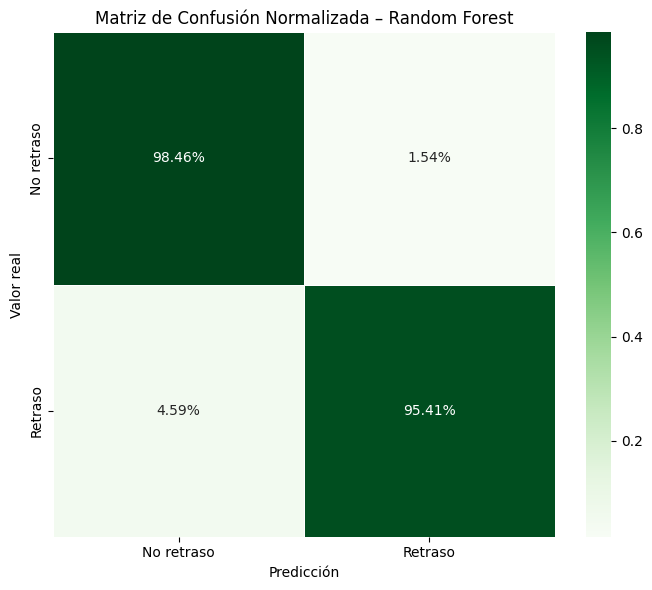

In [ ]:
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2%',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels,
    cbar=True,
    linewidths=0.5
)

plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión Normalizada – Random Forest')
plt.tight_layout()
plt.show()


In [ ]:
# Importancia de variables
import pandas as pd

importancias1 = pd.DataFrame({
    'Variable': X_train_valid1.columns,
    'Importancia': best_rf1.feature_importances_
}).sort_values(by='Importancia', ascending=False)

importancias1

,Variable,Importancia
15,DEP_TIME,0.448017
12,CRS_DEP_TIME,0.368326
13,CRS_ARR_TIME,0.069411
10,ORIGIN,0.015229
9,OP_UNIQUE_CARRIER,0.015069
7,DAY_OF_MONTH,0.014687
14,TAIL_NUM,0.014005
11,DEST,0.012385
1,mes_cos,0.011935
5,MONTH,0.009799


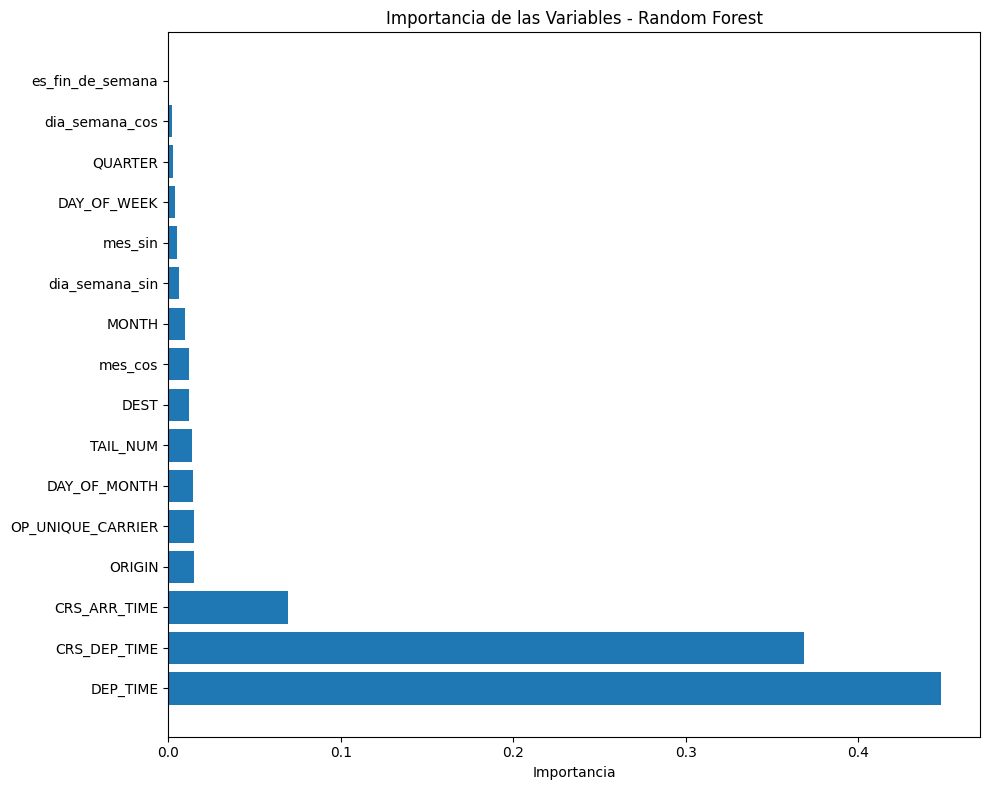

In [ ]:
# Graficar
plt.figure(figsize=(10, 8))
plt.barh(importancias1['Variable'], importancias1['Importancia'])
plt.xlabel('Importancia')
plt.title('Importancia de las Variables - Random Forest')
plt.tight_layout()
plt.show()

### **Curva ROC-AUC -Intento 4**




In [ ]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    f1_score
)

In [ ]:
# 1. Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob1) #best_rf1

In [ ]:
# 2. Calcular AUC roc_auc = roc_auc_score(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_pred_prob1)

In [ ]:
import matplotlib.pyplot as plt

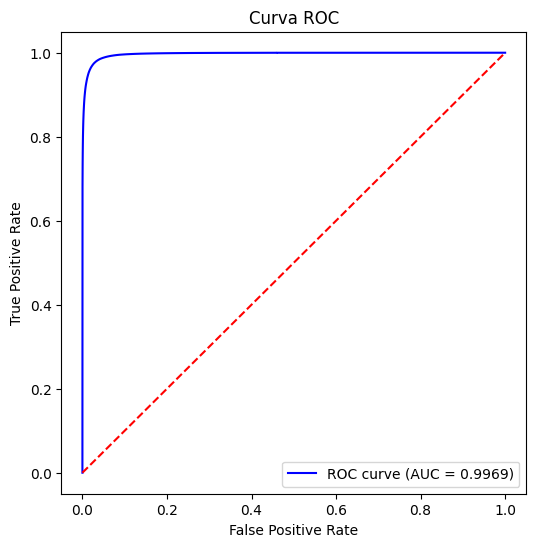

In [ ]:
# 3. Graficar curva ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')  # línea aleatoria
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Más a la izquierda y arriba es mejor.

### **Curva Precision - Recall- Intento 4**

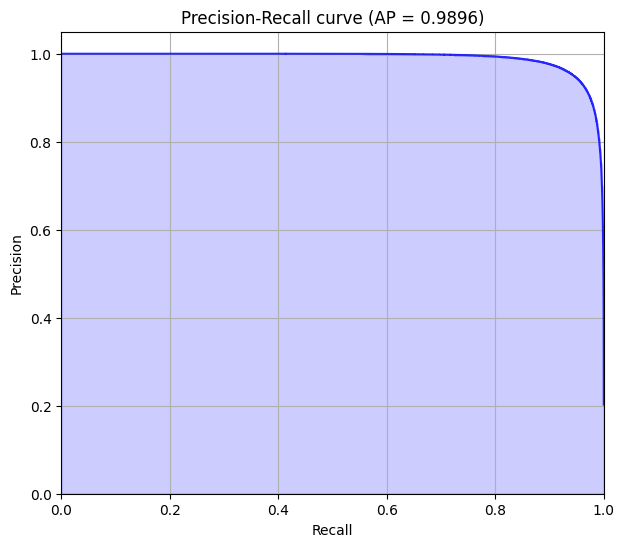

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# y_true: etiquetas 0/1; y_scores: probabilidades para la clase positiva
# Ejemplo:
# y_true = ...
# y_scores = model.predict_proba(X_test)[:,1]

#y_pred1 = best_rf1.predict(X_test_valid1)
#y_pred_prob1 = best_rf1.predict_proba(X_test_valid1)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob1)
ap = average_precision_score(y_test, y_pred_prob1)

plt.figure(figsize=(7,6))
plt.step(recall, precision, where='post', color='b', alpha=0.8)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {ap:.4f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(True)
plt.show()

Mientras más a la derecha y arriba es mejor.

In [ ]:
importancias1.to_csv(
    "random_forest_intento4_importancia.csv",
    index=False
)

## 11. Exportación del modelo

In [ ]:
import joblib

In [ ]:
# Definir función de features engineering
def feature_engineering(df):
    df = df.copy()

    df['anio'] = df['FL_DATE'].dt.year
    df['mes'] = df['FL_DATE'].dt.month
    df['dia_semana'] = df['FL_DATE'].dt.dayofweek

    df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)

    df['dia_semana_sin'] = np.sin(2 * np.pi * df['dia_semana'] / 7)
    df['dia_semana_cos'] = np.cos(2 * np.pi * df['dia_semana'] / 7)

    df['es_fin_de_semana'] = (df['dia_semana'] >= 5).astype(int)

    return df


In [ ]:
rf_artifact = {
    "model": best_rf1,
    "encoders": encoders,                 # dict de LabelEncoder por columna
    "feature_engineering": feature_engineering,
    "features": variables_validas1        # orden exacto
}

In [ ]:
joblib.dump(
    rf_artifact,
    "random_forest_version2.joblib",compress=3
)

['random_forest_version2.joblib']

In [ ]:
joblib.dump(
    rf_artifact,
    "random_forest_version2.pkl",compress=3
)

['random_forest_version2.pkl']

In [ ]:
df.shape

(6915279, 36)

**El modelo falla al hacer predicciones, esto se debe a data leakage producto de incorporar ```DEP_TIME```que corresponde a la hora de salida real. Es por esto que en el siguiente notebook se modelará sin esa variable.**